# Pump It Up: Data Mining the Water Table

## Contexto y origen de los datos  

En las zonas rurales de Tanzania, **millones de personas dependen de bombas manuales para acceder a agua potable**. Diversos estudios estiman que **entre un 30 % y un 40 % de estos puntos de agua est√°n fuera de servicio en un momento dado**, lo que obliga a recorrer distancias largas o recurrir a fuentes inseguras. Anticipar qu√© bombas fallar√°n permite programar el mantenimiento antes de que ocurra la aver√≠a, optimizando los recursos limitados de ONG y autoridades locales y **garantizando un suministro continuo y seguro**.

**Proyecto & Fuente**  
Los datos proceden del **Taarifa Waterpoints Dashboard**, una iniciativa *open-source* que recopila y publica informaci√≥n del **Ministerio de Agua de Tanzania**.  
Taarifa funciona como un ‚Äúgestor de incidencias del mundo f√≠sico‚Äù: los ciudadanos notifican problemas en infraestructuras, y los responsables municipales los priorizan y resuelven.  
Este conjunto concreto de registros sirvi√≥ de base al reto ‚Äú**Pump It Up ‚Äì Data Mining the Water Table**‚Äù organizado por DrivenData.

**Objetivo anal√≠tico**  
Predecir en qu√© estado operativo se encuentra cada punto de agua para orientar las tareas de mantenimiento y asegurar el suministro de agua potable.  
La variable a estimar (`status_group`) presenta **tres clases**:  

| Clase | Descripci√≥n | Implicaci√≥n operativa |
|-------|-------------|-----------------------|
| `functional` | Bomba funciona sin incidencias | Visita rutinaria |
| `functional needs repair` | Funciona pero requiere reparaci√≥n | Programar mantenimiento |
| `non functional` | Fuera de servicio | Intervenci√≥n prioritaria |

Una predicci√≥n fiable de fallos permite **optimizar recursos** (tiempo de los t√©cnicos, recambios, presupuesto) y **minimizar tiempos de inactividad** que afectan a las comunidades.

**Variables disponibles (extracto)**  

| Dimensi√≥n | Variables destacadas |
|-----------|----------------------|
| **Ubicaci√≥n y topograf√≠a** | `latitude`, `longitude`, `gps_height`, `basin`, `region`, `district_code`, `lga`, `ward`, `subvillage` |
| **Construcci√≥n y hardware** | `construction_year`, `extraction_type`, `extraction_type_group`, `extraction_type_class`, `waterpoint_type`, `waterpoint_type_group` |
| **Gesti√≥n y financiaci√≥n** | `funder`, `installer`, `scheme_management`, `management`, `management_group`, `payment`, `payment_type`, `permit` |
| **Demanda y contexto social** | `population`, `public_meeting` |
| **Calidad y cantidad de agua** | `water_quality`, `quality_group`, `quantity`, `quantity_group`, `source`, `source_type`, `source_class` |
| **Meta-datos de registro** | `date_recorded`, `recorded_by`, `wpt_name`, `num_private`, `amount_tsh` |

En total, el dataset incluye **‚âà 37 atributos explicativos** (categ√≥ricos y num√©ricos) que capturan la **ubicaci√≥n**, el **dise√±o t√©cnico**, el **modelo de gesti√≥n** y el **entorno socio-demogr√°fico** de cada bomba.  
Este abanico de factores ofrece una base rica para **explorar correlaciones** y **construir modelos predictivos** que apoyen la toma de decisiones sobre mantenimiento preventivo.


In [1]:
## lo b√°sico
import pandas as pd
import numpy as np

## visualizaci√≥n
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

## pre procesado
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

## modelado
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## m√©tricas
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import classification_report

## mejora de modelos
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

## automatizaci√≥n
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import impute as skl_imp

import math
from collections import Counter
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from scipy import stats
import missingno as msno
import mlflow
import mlflow.sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import ConfusionMatrixDisplay



# An√°lisis Exploratorio

## Importado de los datos.

### Carga de datos y uni√≥n de datasets.

In [2]:
train = pd.read_csv('datos/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
test = pd.read_csv('datos/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')
labels = pd.read_csv('datos/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')

In [3]:
datasets = (train, test, labels)

In [4]:
for x in datasets:
    print(x.shape)

(59400, 40)
(14850, 40)
(59400, 2)


### Uni√≥n de datos

In [5]:
train['dataset'] = 'train'
test['dataset'] = 'test'
df_train = pd.merge(train, labels, on='id', how='inner')

In [6]:
df_train.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... quality_group  \
0  34.938093  -9.856322                  none            0  ...          good   
1  34.698766  -2.147466              Zahanati            0  ...          good   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          good   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          good   
4  31.130847  -1.825359               Shuleni            0  ...          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type  waterpoint_type_group dataset  \
0  groundwater           communal standpipe     communal standpipe   train   
1      surface           communal standpipe     communal standpipe   train   
2      surface  communal standpipe multiple     communal standpipe   train   
3  groundwater  communal standpipe multiple     communal standpipe   train   
4      surface           communal standpipe     communal standpipe   train   

     status_group  
0      functional  
1      functional  
2      functional  
3  non functional  
4      functional  

[5 rows x 42 columns]

In [7]:
df_final = pd.concat([df_train, test], axis=0)

## Exploracion inicial de los datos

In [8]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74250 entries, 0 to 14849
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69743 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74248 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lga    

In [9]:
df_final.describe()

id     amount_tsh    gps_height     longitude      latitude  \
count  74250.000000   74250.000000  74250.000000  74250.000000  7.425000e+04   
mean   37124.500000     318.685704    665.667313     34.074262 -5.701771e+00   
std    21434.273081    2906.762364    692.761033      6.572519  2.944969e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18562.250000       0.000000      0.000000     33.086819 -8.525675e+00   
50%    37124.500000       0.000000    364.000000     34.907475 -5.026540e+00   
75%    55686.750000      20.000000   1317.000000     37.181685 -3.325058e+00   
max    74249.000000  350000.000000   2777.000000     40.345193 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  74250.000000  74250.000000   74250.000000  74250.000000   
mean       0.462330     15.265414       5.629077    180.750828   
std       11.537879     17.508907       9.641636    471.086120   
min        0.000000      1.000000       0.000000      0.000000   
25%        0.000000      5.000000       2.000000      0.000000   
50%        0.000000     12.000000       3.000000     25.000000   
75%        0.000000     17.000000       5.000000    215.000000   
max     1776.000000     99.000000      80.000000  30500.000000   

       construction_year  
count       74250.000000  
mean         1298.463650  
std           952.349375  
min             0.000000  
25%             0.000000  
50%          1986.000000  
75%          2004.000000  
max          2013.000000

In [31]:
report = ProfileReport(df_final)
report.to_file('df_final.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|          | 0/42 [00:00<?, ?it/s]
%|‚ñè         | 1/42 [00:03<01:57,  2.86s/it]
%|‚ñç         | 2/42 [00:03<01:01,  1.53s/it]
%|‚ñã         | 3/42 [00:03<00:38,  1.01it/s]
%|‚ñâ         | 4/42 [00:04<00:31,  1.22it/s]
%|‚ñà‚ñè        | 5/42 [00:04<00:25,  1.45it/s]
%|‚ñà‚ñç        | 6/42 [00:05<00:19,  1.89it/s]
%|‚ñà‚ñã        | 7/42 [00:05<00:15,  2.29it/s]
%|‚ñà‚ñâ        | 8/42 [00:05<00:11,  2.92it/s]
%|‚ñà‚ñà‚ñè       | 9/42 [00:07<00:31,  1.06it/s]
%|‚ñà‚ñà‚ñç       | 10/42 [00:07<00:23,  1.36it/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:09<00:00,  4.32it/s]
C:\Users\migue\anaconda3\envs\ML2025\Lib\site-packages\ydata_profiling\model\correlations.py:87: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Tipos de variable

La variable `date_recorded` contiene la fecha de registro de cada observaci√≥n, pero actualmente est√° almacenada como texto (`object`).  
Para poder trabajar correctamente con esta variable en an√°lisis posteriores, se convertir√° a tipo `datetime` utilizando `pd.to_datetime()`.

In [11]:
df_final['date_recorded'] = pd.to_datetime(df_final['date_recorded'], errors='coerce')

### Detecci√≥n de errores de codificaci√≥n en variables de alta cardinalidad

Algunas variables del dataset presentan una alta cardinalidad, es decir, un n√∫mero muy elevado de categor√≠as distintas.  
Para identificar posibles errores de codificaci√≥n (por ejemplo, diferencias por espacios, may√∫sculas o errores ortogr√°ficos), se normalizar√°n los textos y se revisar√°n aquellas categor√≠as que aparecen con muy baja frecuencia (menos de 5 veces).


In [27]:
# Hacemos una lista de las variables de alta cardinalidad. 
vars_high_cardinality = ['funder', 'installer', 'scheme_name', 'ward', 'lga']

# Para cada variable en la lista
for var in vars_high_cardinality:
    print(f'\nVariable: {var}')
        
    # Normalizamos texto: min√∫sculas, quitamos espacios
    temp_series = df_final[var].astype(str).str.lower().str.strip()
    
    # Vemos las categor√≠as que aparecen menos de 5 veces
    rare_categories = temp_series.value_counts()[temp_series.value_counts() < 5]
    
    # Mostramos las rarezas
    print(f'N√∫mero de categor√≠as raras (<5 apariciones): {len(rare_categories)}')
    print(rare_categories.head(10))  



Variable: funder
N√∫mero de categor√≠as raras (<5 apariciones): 1511
funder
railway                          4
netherland                       4
saleh zaharani                   4
h/w                              4
schoo                            4
scott                            4
wvc                              4
colonial government              4
koica and tanzania government    4
simavi                           4
Name: count, dtype: int64

Variable: installer
N√∫mero de categor√≠as raras (<5 apariciones): 1525
installer
lgcdg                        4
tanas                        4
marti                        4
cast                         4
kk                           4
gachuma ginery               4
geita goldmain               4
patuu                        4
ha                           4
nyakilangani construction    4
Name: count, dtype: int64

Variable: scheme_name
N√∫mero de categor√≠as raras (<5 apariciones): 1239
scheme_name
kipara                               4
ma

No se detectan errores de codificaci√≥n evidentes.  
Las categor√≠as poco frecuentes se tratar√°n posteriormente mediante agrupaci√≥n o codificaci√≥n espec√≠fica antes del modelado.

## Inspecci√≥n gr√°fica de variables

### Distribuciones y calidades de las variables  

Antes de construir el pipeline es clave **ver la forma y la calidad** de cada variable para:

1. Detectar **asimetr√≠as extremas** y decidir transformaciones (log, binning).
2. Localizar **outliers reales** frente a errores de captura.
3. Identificar **categor√≠as con muy poca frecuencia** que generen ruido al codificar.
4. Marcar **ausencias** que puedan ser informativas (p. ej. permisos desconocidos).

En los siguientes gr√°ficos se muestran:
- **Boxplots** para variables num√©ricas  
- **Histogramas** para categ√≥ricas de baja cardinalidad (< 20 niveles)  

Al final de la secci√≥n resumimos los hallazgos y c√≥mo se plasman en el preprocesado.



In [31]:
num_vars = df_final.select_dtypes(include='number').columns.tolist()
low_cardinality_vars = []
for var in df_final.select_dtypes(include='object').columns:
    if df_final[var].nunique() < 20:
        low_cardinality_vars.append(var)

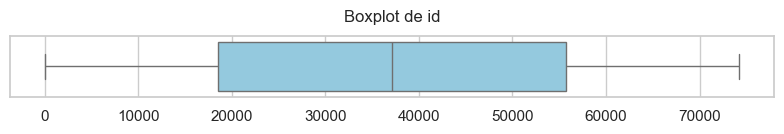

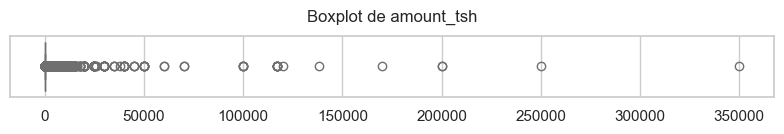

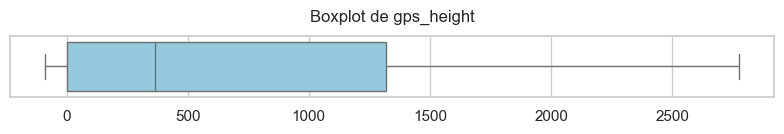

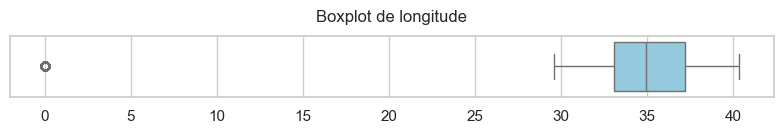

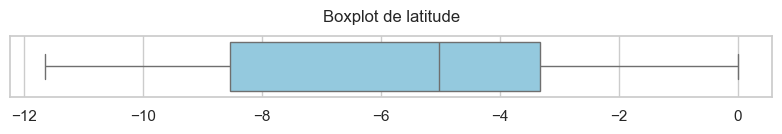

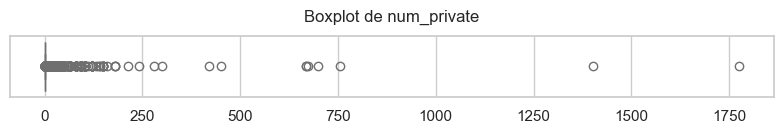

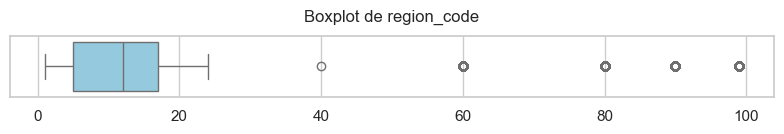

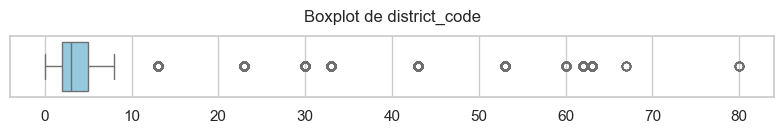

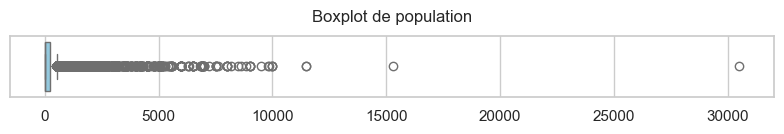

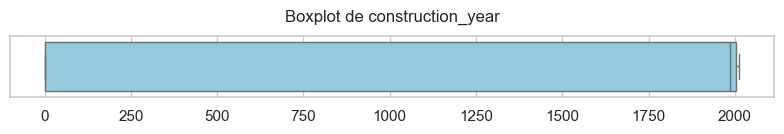

In [37]:
sns.set(style="whitegrid")

for var in num_vars:
    plt.figure(figsize=(8, 1.5))  
    sns.boxplot(x=df_final[var], color="skyblue", linewidth=1)
    plt.title(f'Boxplot de {var}', fontsize=12, pad=10)
    plt.xlabel('')
    plt.yticks([])
    plt.tight_layout()
    plt.show()

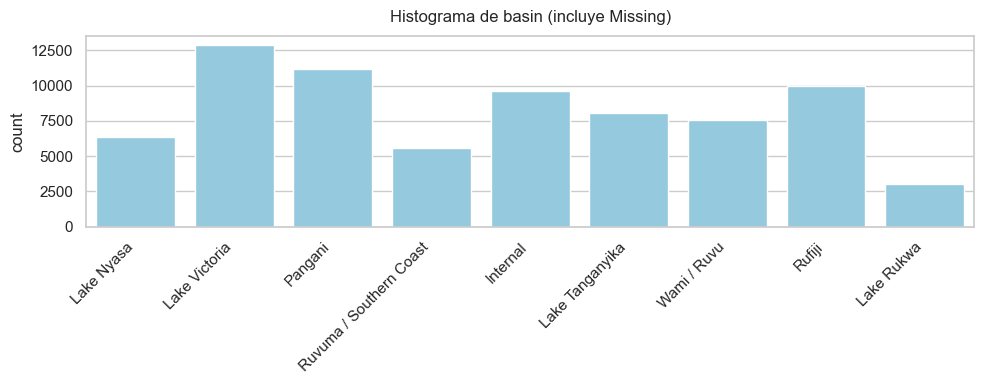

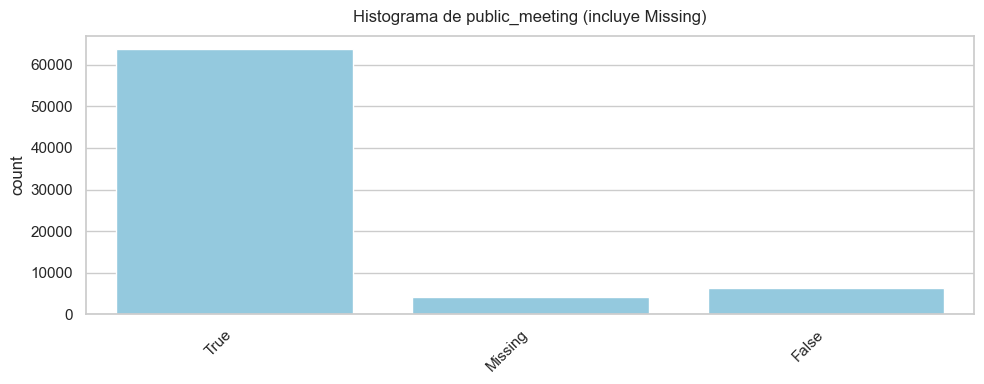

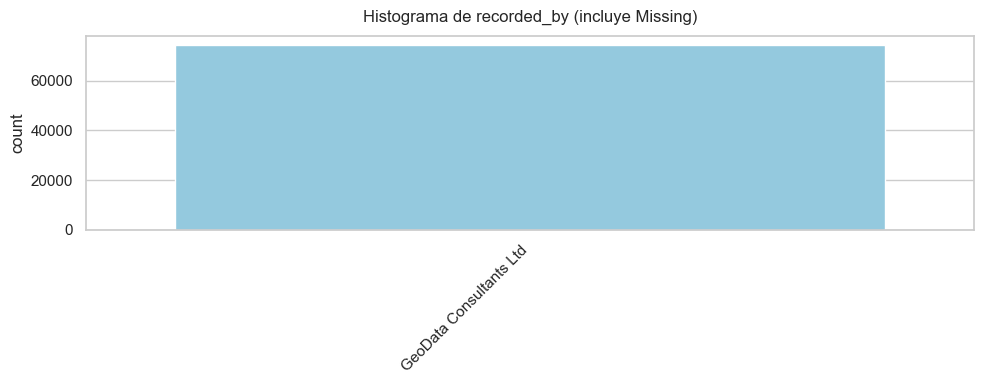

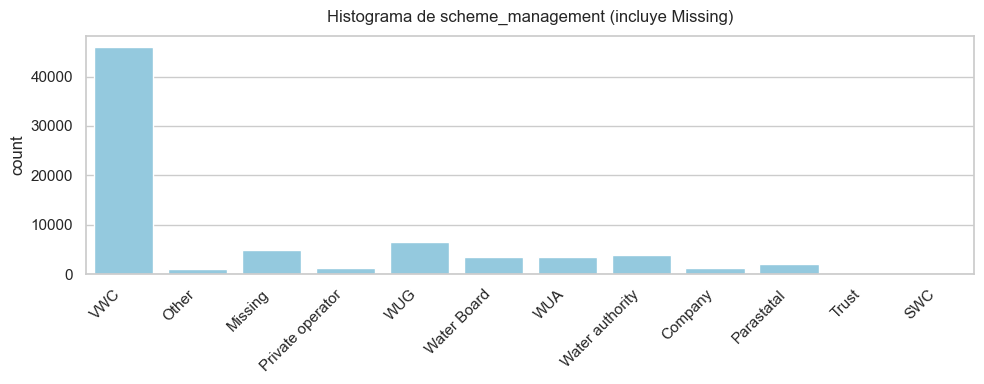

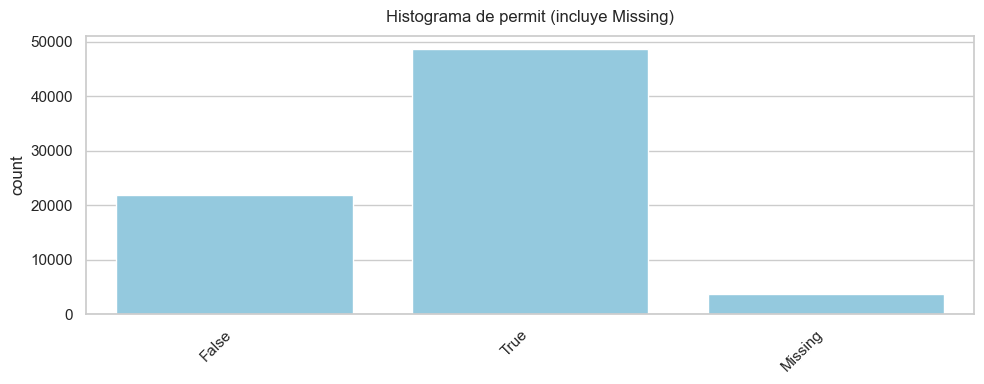

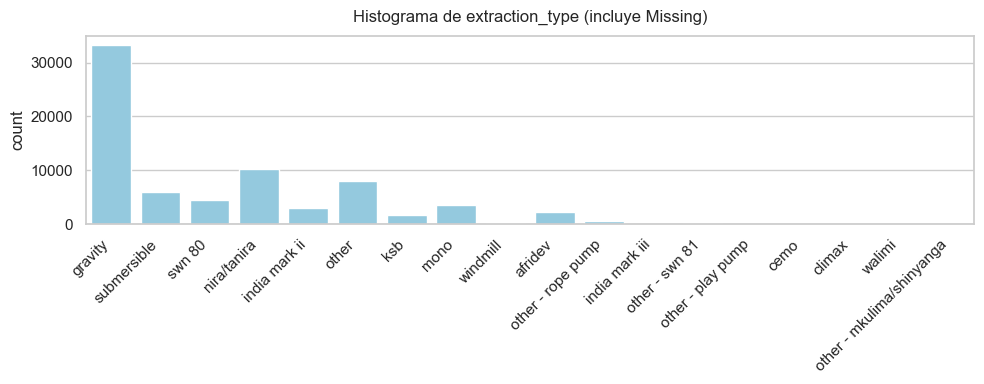

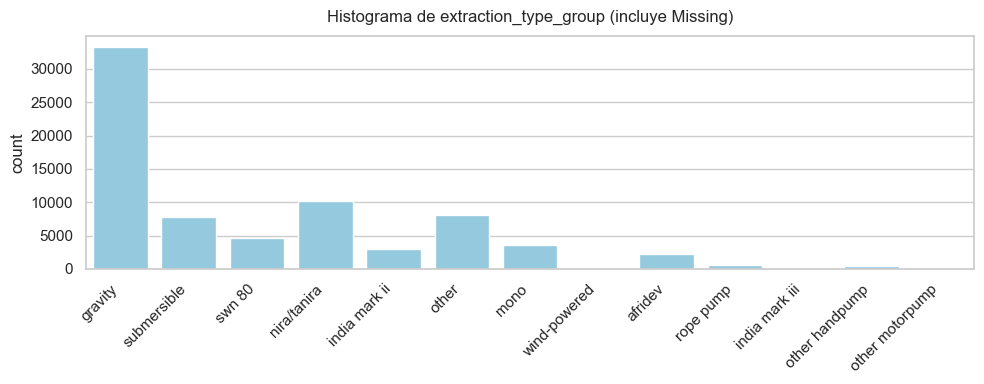

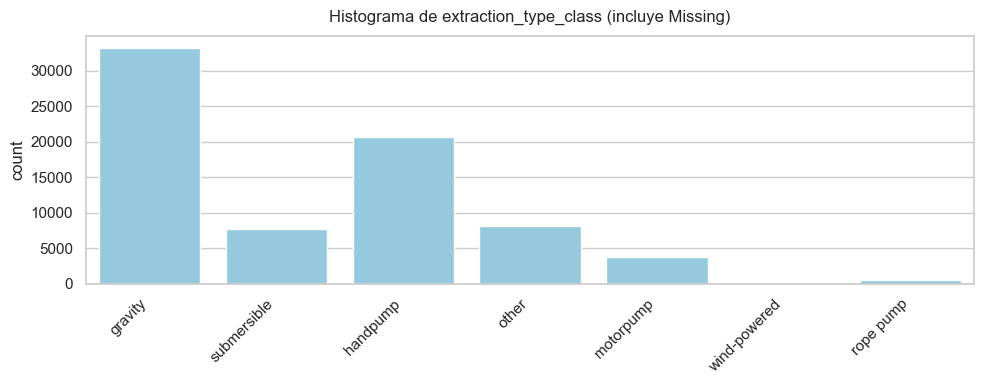

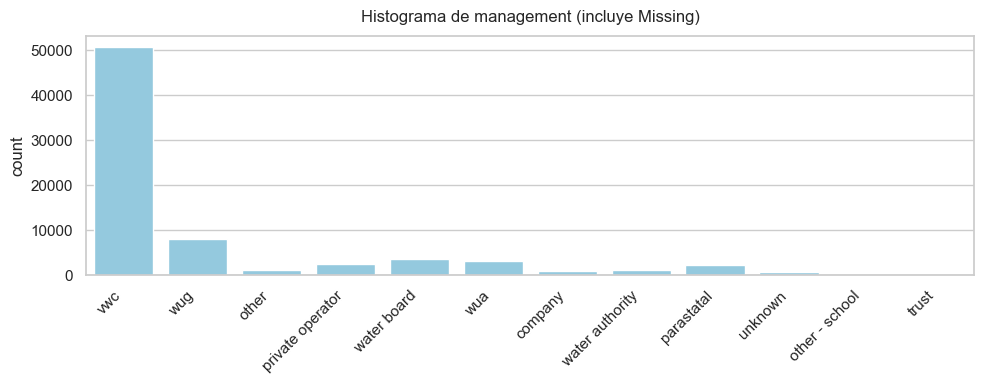

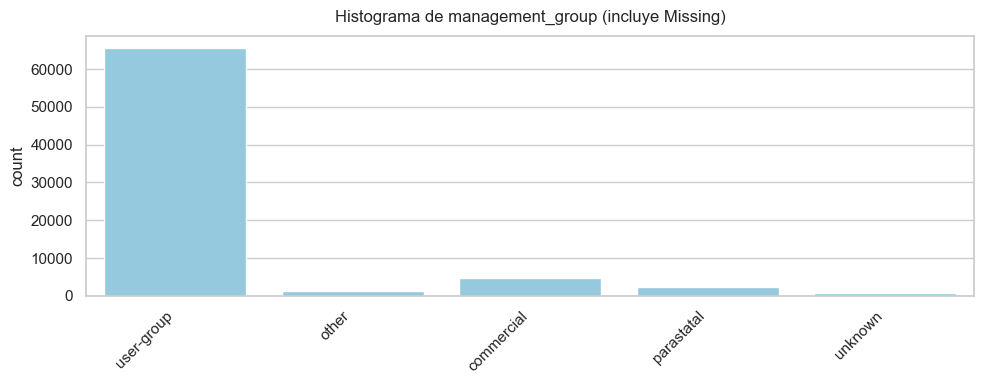

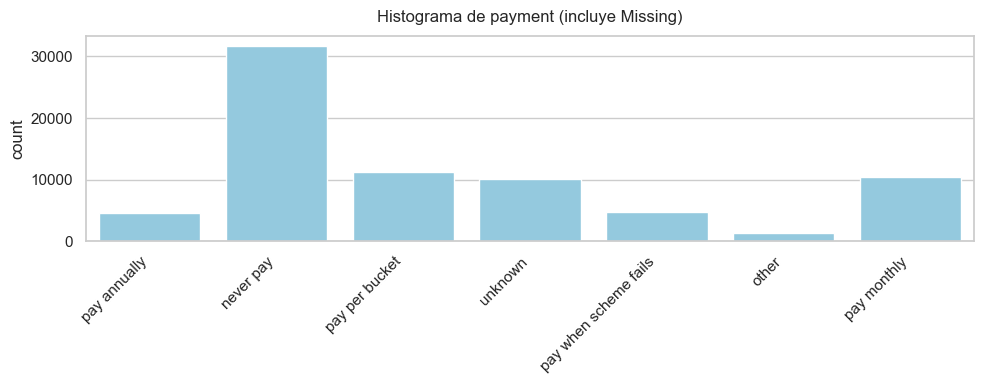

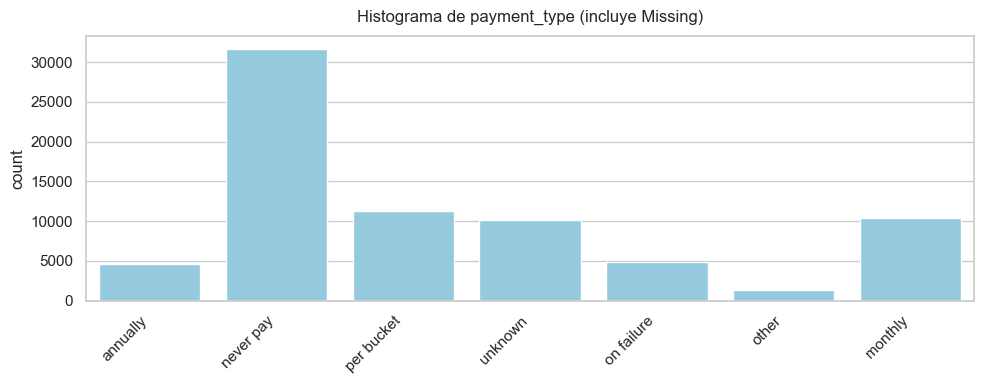

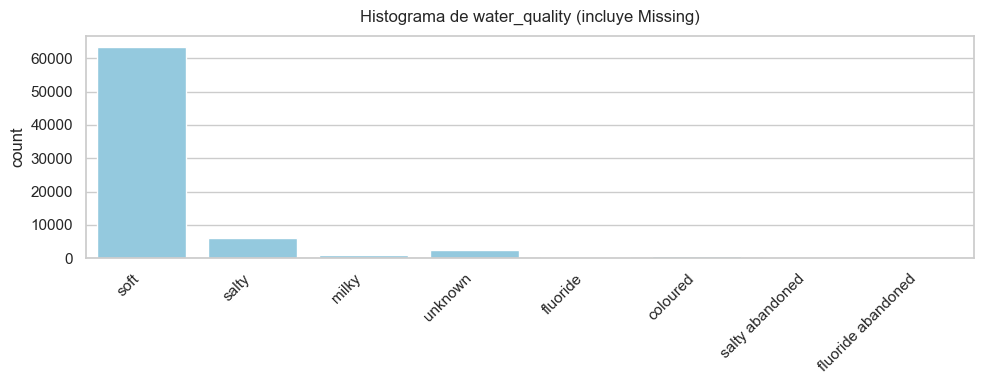

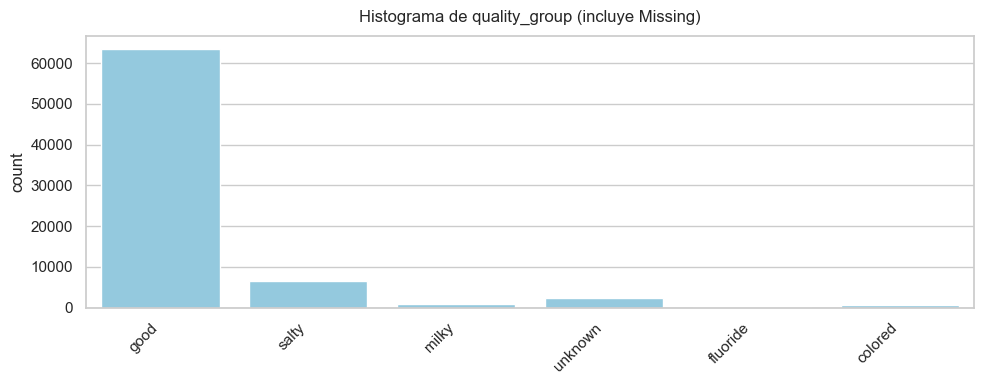

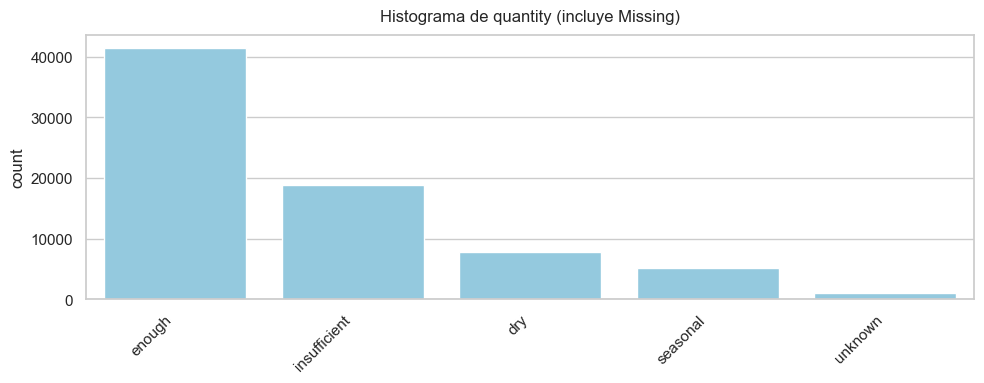

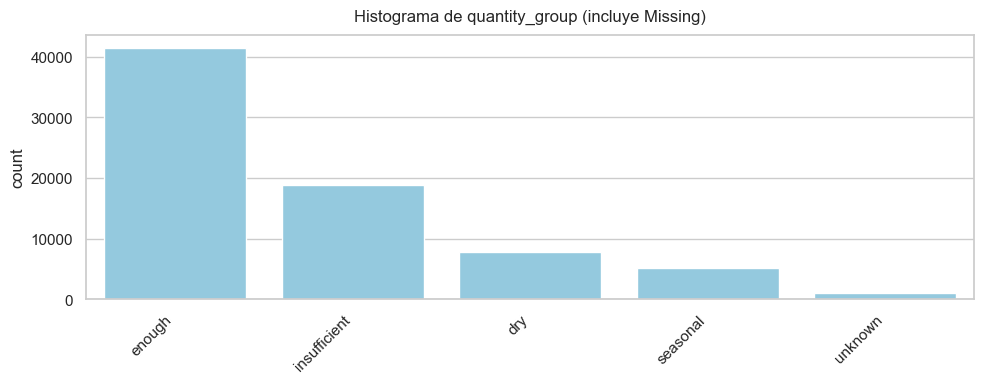

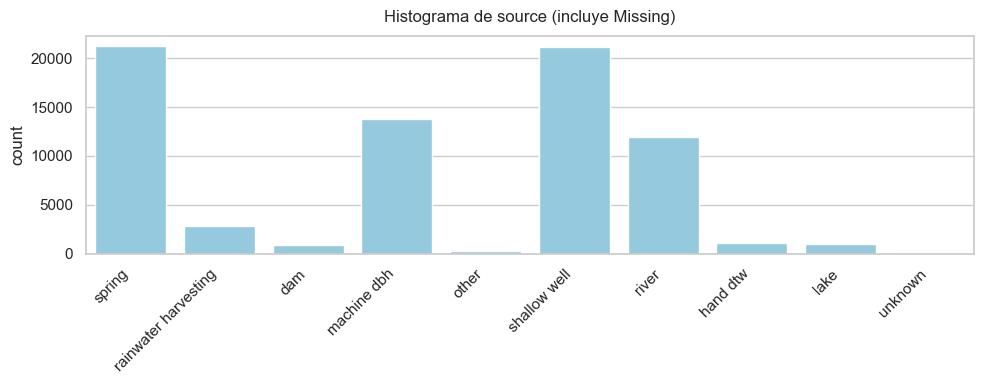

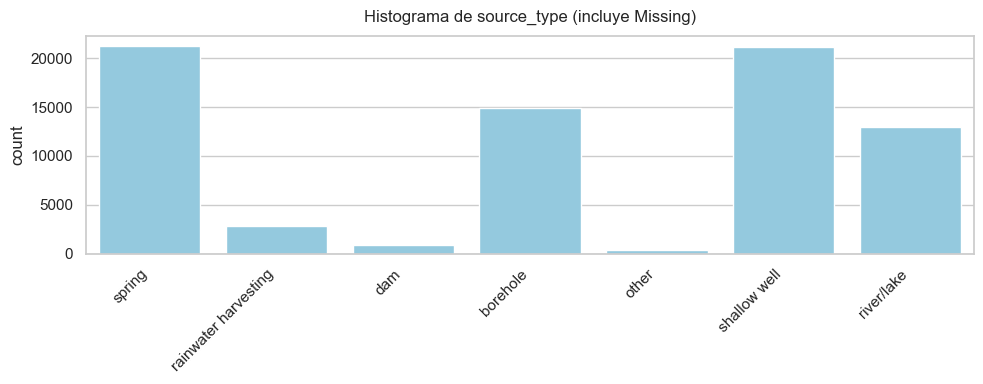

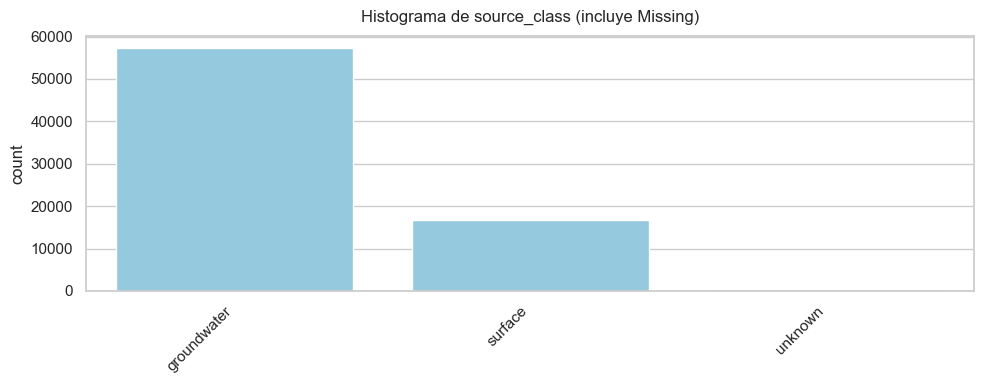

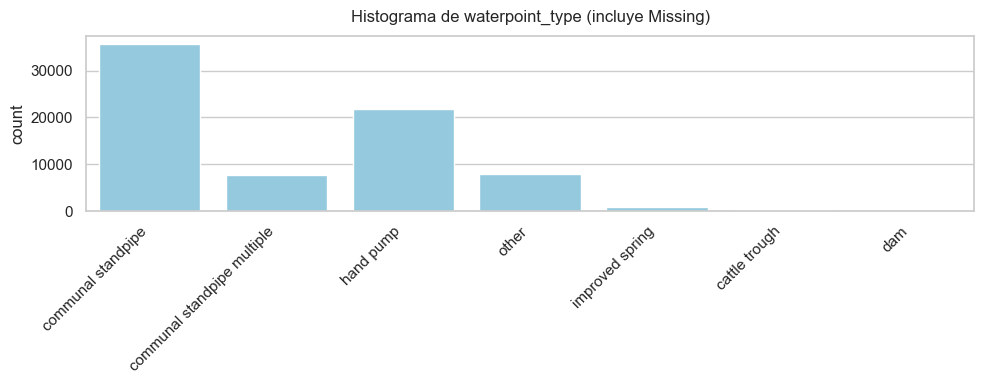

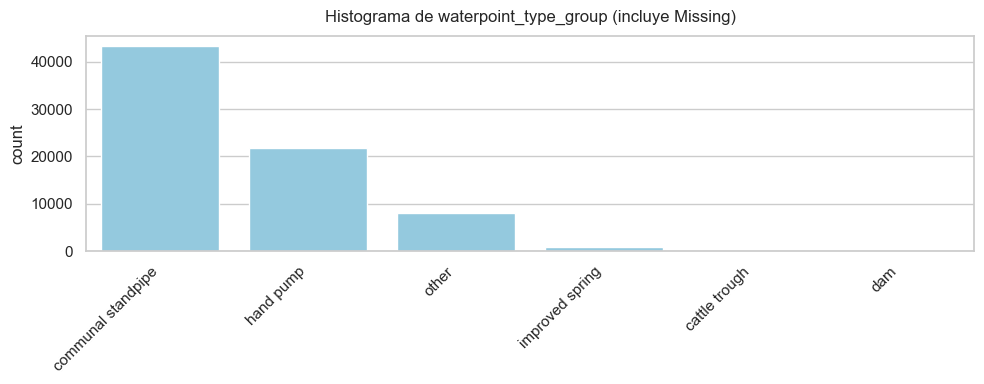

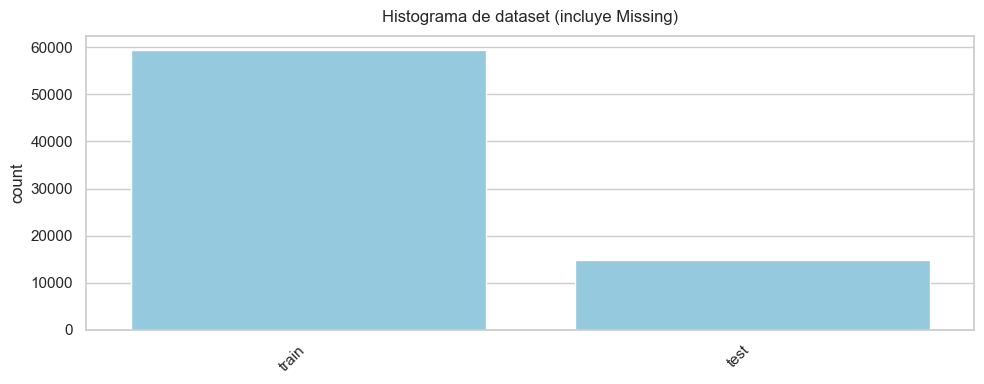

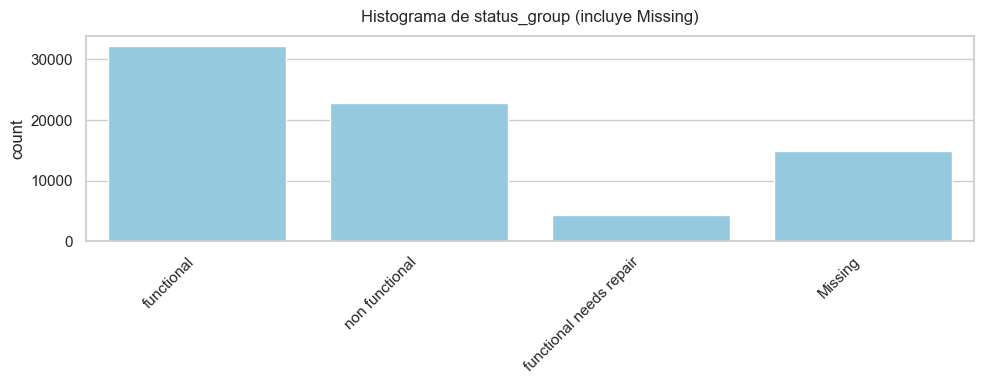

In [40]:
# Resetear √≠ndice para evitar errores
df_final = df_final.reset_index(drop=True)

# Estilo general
sns.set(style="whitegrid")

for var in low_cardinality_vars:
    plt.figure(figsize=(10, 4))
    
    # Reemplazar temporalmente NaN por 'Missing' para esta variable
    temp_series = df_final[var].fillna('Missing')
    
    sns.countplot(x=temp_series, color="skyblue")
    
    plt.title(f'Histograma de {var} (incluye Missing)', fontsize=12, pad=10)
    plt.xlabel('')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



### Principales hallazgos y decisiones aplicadas  

| Hallazgo | Evidencia vista en los gr√°ficos | Decisi√≥n implementada |
|----------|---------------------------------|--------------------------------------|
| `amount_tsh` y `population` muy sesgadas a la derecha | Boxplots con cola larga y puntos extremos | `log1p()` sobre `amount_tsh` (`amount_tsh_log`) y **binning** de `population` en categor√≠as *rural / semi-urban / urban* (`population_bin`) |
| Altura GPS (`gps_height`) con rango amplio pero sin valores aberrantes | Distribuci√≥n relativamente compacta | Mantener num√©rica y escalar con `StandardScaler` dentro del `ColumnTransformer` |
| **C√≥digos geogr√°ficos** (`region_code`, `district_code`) y **variables de texto** con cientos de valores | Barras inferiores al 1 % de los registros | Agrupar etiquetas infrecuentes con `RareLabelEncoder(threshold = 0.01)` |
| Dominio claro de la categor√≠a **‚Äúgravity‚Äù** en los tres `extraction_type*` | > 30 k registros frente a 1-5 k del resto | Conservar tal cual; codificar con One-Hot (el modelo maneja el desbalance) |
| Campos booleanos con nulos (`public_meeting`, `permit`) | Presencia expl√≠cita de ‚ÄúMissing‚Äù en histos | Mapear a la categor√≠a **`'Unknown'`** (`*_cat` variables) antes de One-Hot |
| Bombas muy antiguas concentran fallos | `construction_year` < 1980 casi siempre no funcional | Nueva variable binaria `is_old_construction` |

> **Resultado:** las num√©ricas quedan sin sesgos extremos, las categ√≥ricas con cardinalidad controlada y los nulos convertidos en informaci√≥n √∫til. Todo esto se encapsula en el `Pipeline` (`preprocessor` + `XGBClassifier`) que ya entrenas a partir de la celda 136.


## Aplicaci√≥n de correcciones a las variables num√©ricas

En este apartado se aplican las primeras correcciones b√°sicas sobre las variables num√©ricas del conjunto de datos. El objetivo es detectar y corregir errores evidentes en los datos, como valores imposibles o codificaciones incorrectas

In [41]:
df_final['gps_height'] = df_final['gps_height'].apply(lambda x: np.nan if x<0 else x)
df_final['longitude'] = df_final['longitude'].apply(lambda x: np.nan if x==0 else x)
df_final['region_code'] = df_final['region_code'].astype('object')
df_final['district_code'] = df_final['district_code'].astype('object')
df_final['construction_year'] = df_final['construction_year'].apply(lambda x: np.nan if x==0 else x)

- `gps_height`: Los valores negativos no tienen sentido geogr√°fico en Tanzania, por lo que se han reemplazado por valores nulos (`NaN`).
- `longitude`: Un valor de longitud igual a 0 es inv√°lido en este contexto y se ha tratado como valor nulo (`NaN`).
- `construction_year`: El a√±o de construcci√≥n igual a 0 indica falta de informaci√≥n, por lo que tambi√©n se ha convertido en valor nulo (`NaN`).
- `region_code` y `district_code`: Aunque tienen formato num√©rico, representan c√≥digos categ√≥ricos. Se han convertido a tipo `object` para tratarlos como variables categ√≥ricas en fases posteriores.

Estas correcciones permiten limpiar errores de origen en los datos sin eliminar informaci√≥n relevante, facilitando as√≠ un an√°lisis m√°s fiable en los siguientes pasos.

## Gesti√≥n de outliers

In [49]:
def gestiona_outliers(col, clas='check'):
    print(f'\nVariable: {col.name}')
    print('--------------------------------------')

    # Criterio 1 basado en asimetr√≠a
    if abs(col.skew()) < 1:
        criterio1 = abs((col - col.mean()) / col.std()) > 3
    else:
        criterio1 = abs((col - col.median()) / stats.median_abs_deviation(col)) > 8

    # Criterio 2 basado en IQR
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    criterio2 = (col < (q1 - 3 * iqr)) | (col > (q3 + 3 * iqr))

    # Combinaci√≥n de criterios
    lower = col[criterio1 & criterio2 & (col < q1)].count() / col.dropna().count()
    upper = col[criterio1 & criterio2 & (col > q3)].count() / col.dropna().count()

    if clas == 'check':
        print(f'Outliers bajos (<Q1-3√óIQR): {lower*100:.2f}%')
        print(f'Outliers altos (>Q3+3√óIQR): {upper*100:.2f}%')
        print(f'Total de outliers detectados: {(lower+upper)*100:.2f}%')
        
    elif clas == 'winsor':
        return winsorize_with_pandas(col, (lower, upper))

    elif clas == 'miss':
        print(f'\nMissing antes: {col.isna().sum()}')
        col.loc[criterio1 & criterio2] = np.nan
        print(f'Missing despu√©s: {col.isna().sum()}')
        return col


In [50]:
gestiona_outliers(df_final['amount_tsh'], clas='check')


Variable: amount_tsh
--------------------------------------
Outliers bajos (<Q1-3√óIQR): 0.00%
Outliers altos (>Q3+3√óIQR): 18.75%
Total de outliers detectados: 18.75%


In [51]:
gestiona_outliers(df_final['population'], clas='check')


Variable: population
--------------------------------------
Outliers bajos (<Q1-3√óIQR): 0.00%
Outliers altos (>Q3+3√óIQR): 3.33%
Total de outliers detectados: 3.33%


In [53]:
df_final['amount_tsh_log'] = np.log1p(df_final['amount_tsh'])

Se ha analizado la presencia de valores extremos en las variables num√©ricas mediante una combinaci√≥n de criterios robustos basados en la asimetr√≠a de la variable y su dispersi√≥n respecto al IQR. A partir de este an√°lisis, se han tomado las siguientes decisiones:

- `amount_tsh`: presenta un 18.75% de valores excepcionalmente altos. Debido a la magnitud de estos valores y su clara asimetr√≠a, se ha creado una transformaci√≥n logar√≠tmica (`log1p`) para suavizar su escala y reducir el impacto relativo de los valores extremos sin perder informaci√≥n.
  
- `population`: presenta un 3.33% de valores extremos. Dado que la proporci√≥n es baja y la variable tiene una interpretaci√≥n directa, se ha decidido conservarla sin modificaciones para preservar su distribuci√≥n original.

Estas transformaciones permiten mantener la informaci√≥n contenida en las variables al tiempo que se reducen los posibles efectos distorsionadores de los valores at√≠picos en fases posteriores del an√°lisis.


## An√°lisis de incidencia de missings

### Identificamos que variables tienen missings

In [57]:
df_final.apply(lambda x: x.isna().sum()/df_final.shape[0]*100)

id                        0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    6.070034
gps_height                2.533333
installer                 6.103704
longitude                 3.055892
latitude                  0.000000
wpt_name                  0.002694
num_private               0.000000
basin                     0.000000
subvillage                0.632997
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.595960
recorded_by               0.000000
scheme_management         6.527946
scheme_name              48.554882
permit                    5.108418
construction_year        34.975084
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

### Analisis de la proporci√≥n de missings por registro

In [58]:
df_final['prop_missings'] = df_final.apply(lambda x: x.isna().sum()/df_final.shape[1]*100, axis=1)
df_final.prop_missings.describe()

count    74250.000000
mean         3.236301
std          2.902138
min          0.000000
25%          0.000000
50%          2.325581
75%          4.651163
max         18.604651
Name: prop_missings, dtype: float64

In [60]:
df_final.sort_values(by='prop_missings', ascending=False).head(25)


id  amount_tsh date_recorded                         funder  \
64979  67318         0.0    2013-03-11                            NaN   
63832  28364         0.0    2013-03-19                            NaN   
25463   9846         0.0    2012-10-30                            NaN   
59505  17873         0.0    2012-10-19                            NaN   
59344   6450         0.0    2013-10-03                            NaN   
36032  66687         0.0    2013-10-03                            NaN   
54290  58037         0.0    2013-03-03                            NaN   
21690  71282         0.0    2013-03-19                            NaN   
27798  65087         0.0    2013-03-19                            NaN   
70222  34155         0.0    2012-10-04                            NaN   
68448  28795         0.0    2011-08-05                            NaN   
11968  19795         0.0    2013-03-14                            NaN   
61135  42398         0.0    2013-03-03  Koica And Tanzania Government   
62391  62315         0.0    2013-02-11                            NaN   
46422  67675         0.0    2013-02-02                            NaN   
70233  41614         0.0    2012-10-26                            NaN   
13754  52485         0.0    2013-03-17                            NaN   
73913   4236         0.0    2013-03-16                            NaN   
28946  70660         0.0    2013-03-21                            NaN   
21864  54819         0.0    2013-02-14                            NaN   
61906  14086         0.0    2011-02-22                            NaN   
65920  21294         0.0    2011-08-05                            NaN   
43663  58315         0.0    2013-02-02                            NaN   
17344  21640         0.0    2013-03-03  Koica And Tanzania Government   
63498  34997         0.0    2013-03-27                            NaN   

       gps_height installer  longitude      latitude  \
64979      1283.0       NaN  36.555235 -3.457174e+00   
63832       989.0       NaN  36.962775 -3.426325e+00   
25463         0.0       NaN        NaN -2.000000e-08   
59505         0.0       NaN  32.305549 -3.508052e+00   
59344      1303.0       NaN  36.900911 -3.111477e+00   
36032      1304.0       NaN  36.900464 -3.112022e+00   
54290         0.0       NaN        NaN -2.000000e-08   
21690      1289.0       NaN  36.189340 -3.422393e+00   
27798      1143.0       NaN  36.320944 -2.823900e+00   
70222         0.0       NaN  32.737229 -3.390726e+00   
68448         0.0       NaN  31.791383 -1.335247e+00   
11968      1287.0       NaN  36.760284 -3.388704e+00   
61135         0.0       NaN        NaN -2.000000e-08   
62391      1300.0       NaN  34.284435 -1.691002e+00   
46422         0.0       NaN        NaN -2.000000e-08   
70233         0.0       NaN        NaN -2.000000e-08   
13754      1035.0       NaN  36.091621 -3.554980e+00   
73913        67.0       NaN  39.090742 -6.981723e+00   
28946      1845.0       DWE  36.704560 -3.145754e+00   
21864         0.0       NaN        NaN -2.000000e-08   
61906         NaN       NaN  39.830510 -7.832738e+00   
65920         0.0       NaN  33.157302 -2.900536e+00   
43663         0.0       NaN        NaN -2.000000e-08   
17344         0.0       NaN        NaN -2.000000e-08   
63498      1080.0       NaN  37.295469 -3.287766e+00   

                         wpt_name  num_private  ... quantity_group  \
64979             Bomba La Kijiji            0  ...        unknown   
63832                  Mzee Msafi            0  ...        unknown   
25463                        none            0  ...        unknown   
59505                      Mponda            0  ...        unknown   
59344          Pentecoste Swidish            0  ...        unknown   
36032            Zahanati Ngabobo            0  ...        unknown   
54290                        No 3            0  ...        unknown   
21690                 Mongoriondo            0  ...        unknown   
27798                   

<Axes: >

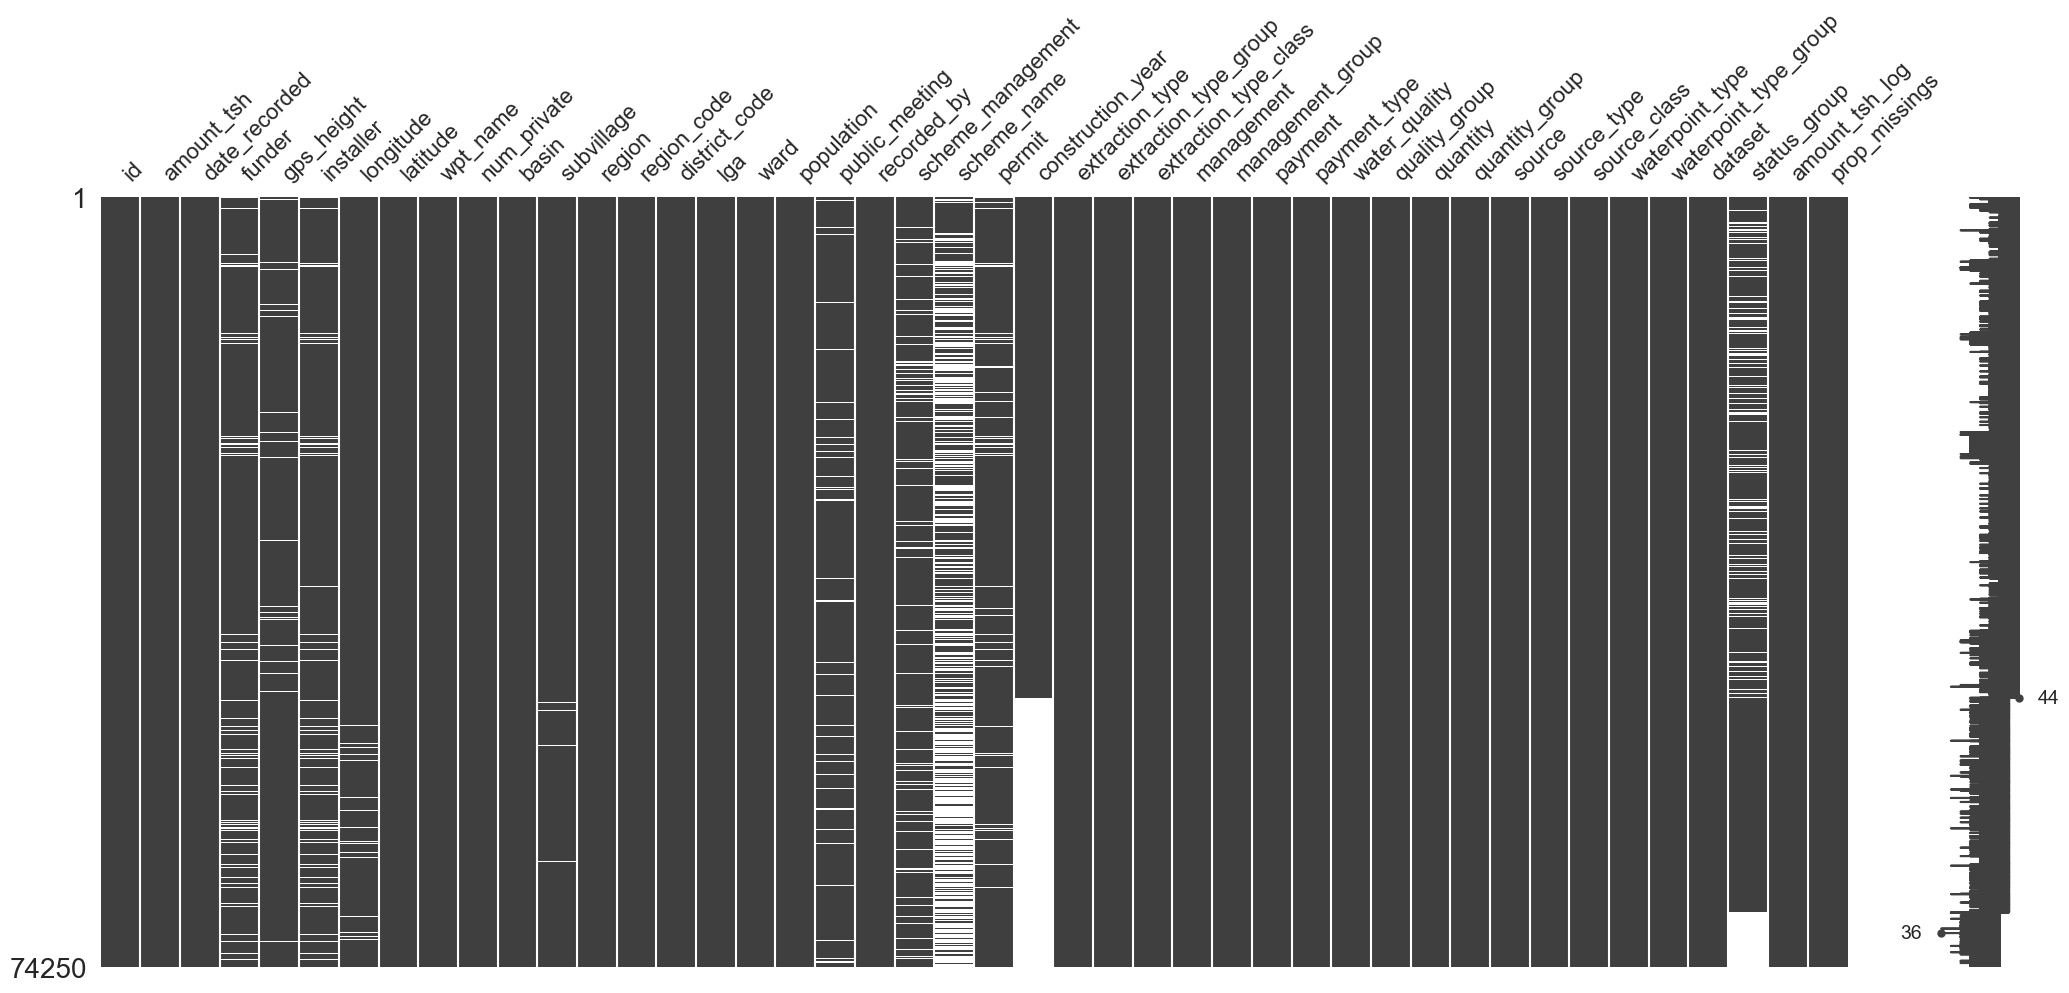

In [61]:
msno.matrix(df_final.sort_values(by='construction_year'))

<Axes: >

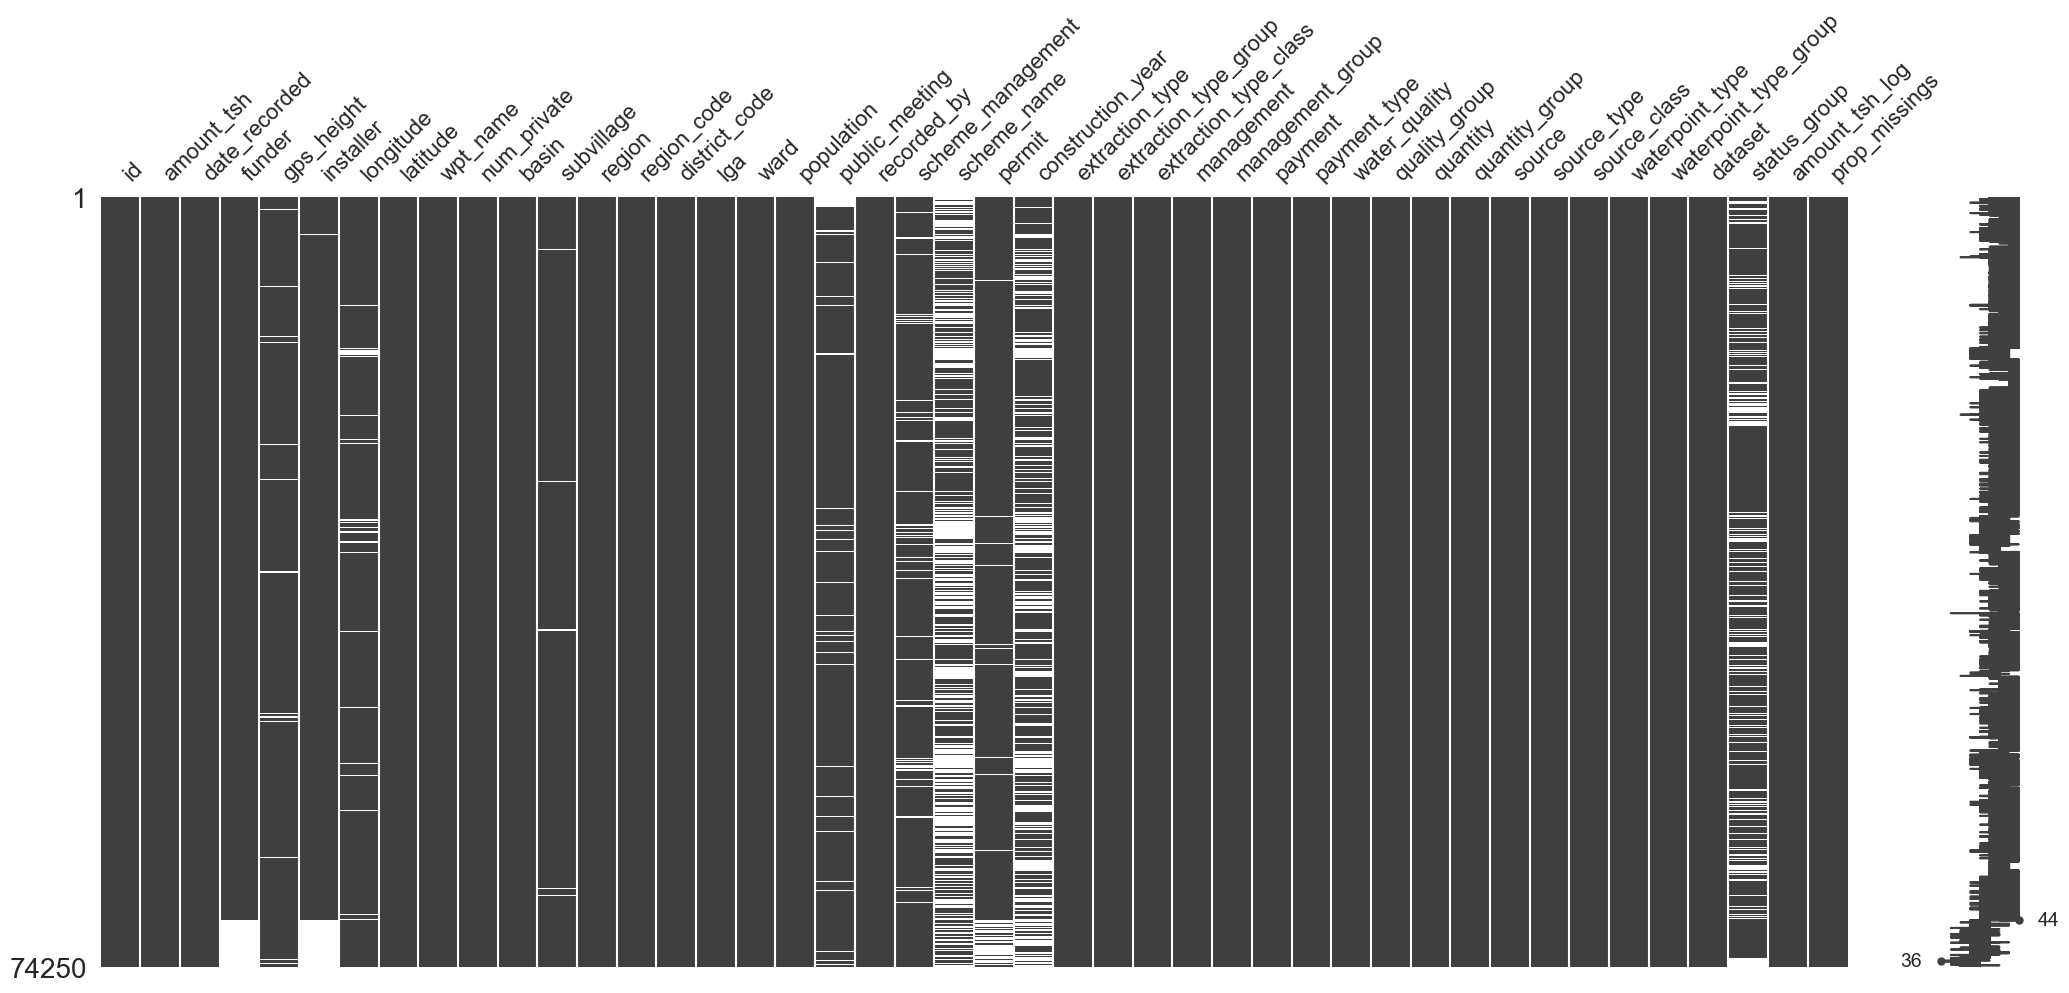

In [63]:
msno.matrix(df_final.sort_values(by='funder'))

Antes de imputar los valores `NaN` del conjunto de datos, se ha realizado una exploraci√≥n visual con una matriz de missingness (`msno.matrix`). Esta herramienta permite observar tanto la distribuci√≥n de los valores faltantes en las columnas como su concentraci√≥n por registros individuales.
Se han generado dos visualizaciones clave:
- Una centrada en la variable `construction_year`, donde se observa que su ausencia suele coincidir con otros campos administrativos incompletos.
- Otra centrada en la variable `funder`, que revela una fuerte presencia de valores faltantes, generalmente acompa√±ada de nulos en `installer`.

Estas visualizaciones permiten identificar patrones de co-ocurrencia de datos ausentes, lo cual es esencial para decidir una estrategia de imputaci√≥n coherente.  
A continuaci√≥n, se abordar√° el tratamiento de los valores faltantes en funci√≥n del tipo de variable y del contexto en que aparecen.


### Tratamiento de valores missing

In [65]:
#Los missing de estas variables son correlados as√≠ que los tratamos juntos
df_final['funder'] = df_final['funder'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_final['installer'] = df_final['installer'].apply(lambda x: 'Unknown' if pd.isna(x) else x)


In [ ]:
#Doble estrategia 
#Mantenemos los Missing como una nueva categor√≠a
df_final['public_meeting_cat'] = df_final['public_meeting'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_final['permit_cat'] = df_final['permit'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_final['scheme_management_cat'] = df_final['scheme_management'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
df_final['subvillage_cat'] = df_final['subvillage'].apply(lambda x: 'Unknown' if pd.isna(x) else x)
#Imputamos por moda
imputer_moda = skl_imp.SimpleImputer(strategy='most_frequent', missing_values=np.nan)

df_final['public_meeting_imp'] = imputer_moda.fit_transform(df_final[['public_meeting']]).ravel()
df_final['permit_imp'] = imputer_moda.fit_transform(df_final[['permit']]).ravel()
df_final['scheme_management_imp'] = imputer_moda.fit_transform(df_final[['scheme_management']]).ravel()
df_final['subvillage_imp'] = imputer_moda.fit_transform(df_final[['subvillage']]).ravel()

# Eliminamos las columnas originales
df_final.drop(columns=['public_meeting', 'permit', 'scheme_management', 'subvillage'], inplace=True)


In [71]:
df_final = df_final.drop('scheme_name', axis=1)

In [87]:
df_final['public_meeting_cat'] = df_final['public_meeting_cat'].astype(str)
df_final['permit_cat'] = df_final['permit_cat'].astype(str)
df_final['scheme_management_cat'] = df_final['scheme_management_cat'].astype(str)
df_final['subvillage_cat'] = df_final['subvillage_cat'].astype(str)


## Tratamiento de valores faltantes en variables categ√≥ricas y booleanas

Se ha aplicado una doble estrategia de tratamiento de valores faltantes en las variables categ√≥ricas y booleanas que presentaban missing:

- **Para las variables `funder` e `installer`**, cuyos valores faltantes mostraban alta correlaci√≥n, se imputaron los `NaN` asign√°ndoles directamente la categor√≠a `"Unknown"`, manteniendo as√≠ la coherencia entre ambas variables.

- **Para las variables `public_meeting`, `permit`, `scheme_management` y `subvillage`**, se dise√±aron dos versiones de cada variable:
  - Una versi√≥n donde los valores faltantes se imputaron creando una nueva categor√≠a expl√≠cita denominada `"Unknown"`, permitiendo que los modelos traten la ausencia de informaci√≥n como una categor√≠a diferenciada (`_cat`).
  - Una segunda versi√≥n donde los valores faltantes se imputaron utilizando la moda de cada variable (`_imp`), manteniendo la distribuci√≥n original de los datos.

- **La variable `scheme_name`**, con m√°s de un 48% de valores faltantes, se ha eliminado del dataset debido a la falta de completitud y al bajo valor que podr√≠a aportar.

Con este planteamiento, se preserva la mayor cantidad de informaci√≥n posible y se habilita la posibilidad de comparar el rendimiento de diferentes estrategias de imputaci√≥n en el modelado posterior.


In [72]:
# 1. Imputar gps_height usando la mediana de lga
df_final['gps_height_imp'] = df_final['gps_height']

for lga in df_final['lga'].unique():
    mediana = df_final.loc[df_final['lga'] == lga, 'gps_height'].median()
    df_final.loc[(df_final['gps_height_imp'].isna()) & (df_final['lga'] == lga), 'gps_height_imp'] = mediana

# 2. Imputar longitude con mediana global
mediana_longitude = df_final['longitude'].median()
df_final['longitude_imp'] = df_final['longitude'].fillna(mediana_longitude)

# 3. Crear variable has_construction_info (1 si tiene a√±o de construcci√≥n, 0 si no)
df_final['has_construction_info'] = df_final['construction_year'].notna().astype(int)


## Tratamiento de valores faltantes en variables num√©ricas

En esta fase se han tratado los valores `NaN` de las variables num√©ricas siguiendo criterios que permiten conservar la informaci√≥n geogr√°fica y temporal m√°s relevante:

- **gps_height**: se ha imputado el valor faltante utilizando la mediana dentro de cada `lga` (Local Government Area), aprovechando la alta granularidad de esta variable para obtener una imputaci√≥n m√°s precisa y localizada.

- **longitude**: se ha imputado mediante la mediana global del dataset, dado que su porcentaje de valores faltantes es reducido y su distribuci√≥n no presenta anomal√≠as significativas.

- **construction_year**: dada la elevada proporci√≥n de valores faltantes (~35%), se ha creado una nueva variable binaria `has_construction_info` que indica si se dispone o no de informaci√≥n sobre el a√±o de construcci√≥n. Esta estrategia permite que los modelos futuros utilicen la ausencia de informaci√≥n como una posible se√±al predictiva.




In [ ]:
df_final.drop(columns=['gps_height', 'longitude', 'prop_missings', 'wpt_name'], inplace=True)


In [85]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     74250 non-null  int64         
 1   amount_tsh             74250 non-null  float64       
 2   date_recorded          74250 non-null  datetime64[ns]
 3   funder                 74250 non-null  object        
 4   installer              74250 non-null  object        
 5   latitude               74250 non-null  float64       
 6   num_private            74250 non-null  int64         
 7   basin                  74250 non-null  object        
 8   region                 74250 non-null  object        
 9   region_code            74250 non-null  object        
 10  district_code          74250 non-null  object        
 11  lga                    74250 non-null  object        
 12  ward                   74250 non-null  object        
 13  p

## Guardado del dataset.
df_unido_limpio.parquet ‚Üí Dataset final tras limpieza de missing, outliers y tratamiento b√°sico de variables. Listo para feature engineering.


In [88]:
df_final.to_parquet('df_unido_limpio.parquet')

# Feature engineering

## Feature engineering
El modelo final no solo depende de los algoritmos, sino de **c√≥mo representamos el problema en variables**. En esta secci√≥n creamos nuevas variables que capturan relaciones no lineales, interacciones y conocimiento de dominio (por ejemplo, la antig√ºedad real de la bomba en a√±os). Cada transformaci√≥n se dise√±a para a√±adir informaci√≥n predictiva sin inflar innecesariamente la dimensionalidad.

In [92]:
df_final = pd.read_parquet('df_unido_limpio.parquet')

In [94]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     74250 non-null  int64         
 1   amount_tsh             74250 non-null  float64       
 2   date_recorded          74250 non-null  datetime64[ns]
 3   funder                 74250 non-null  object        
 4   installer              74250 non-null  object        
 5   latitude               74250 non-null  float64       
 6   num_private            74250 non-null  int64         
 7   basin                  74250 non-null  object        
 8   region                 74250 non-null  object        
 9   region_code            74250 non-null  int64         
 10  district_code          74250 non-null  int64         
 11  lga                    74250 non-null  object        
 12  ward                   74250 non-null  object        
 13  p

## Creaci√≥n de nuevas variables derivadas

In [102]:
# VARIABLES TEMPORALES
# A√±o de registro
df_final['year_recorded'] = df_final['date_recorded'].dt.year
# Mes de registro
df_final['month_recorded'] = df_final['date_recorded'].dt.month
# Trimestre de registro
df_final['recorded_quarter'] = df_final['date_recorded'].dt.quarter
# Edad del pozo
# Para posibles valores negativos: si la fecha de construcci√≥n es despu√©s del registro (datos err√≥neos).
df_final['age'] = df_final['year_recorded'] - df_final['construction_year']
df_final['age'] = df_final['age'].apply(lambda x: np.nan if x < 0 else x)
# VARIABLES SOBRE CANTIDAD DE AGUA
#¬øPozo sin cantidad de agua (0)?
df_final['zero_amount_tsh'] = (df_final['amount_tsh'] == 0).astype(int)                                       

Se han generado nuevas variables a partir de las variables originales `date_recorded`, `construction_year` y `amount_tsh`, con el objetivo de capturar informaci√≥n temporal relevante y caracter√≠sticas f√≠sicas del pozo:

- A partir de `date_recorded`, se han extra√≠do el a√±o (`year_recorded`), el mes (`month_recorded`) y el trimestre (`recorded_quarter`) en que se registr√≥ el pozo, para identificar posibles patrones estacionales o tendencias temporales.
- Se ha calculado la edad de cada pozo (`age`) como la diferencia entre el a√±o de registro y el a√±o de construcci√≥n, marcando como `NaN` los casos en los que la edad resultase negativa, ya que indicar√≠an inconsistencias en los datos originales.
- Se ha creado una variable binaria (`zero_amount_tsh`) que indica si el pozo presenta una cantidad de agua igual a cero, lo cual puede ser un fuerte indicador de un posible fallo o mal funcionamiento.

Estas nuevas variables permiten enriquecer el conjunto de datos con informaci√≥n derivada que podr√≠a ser determinante en la predicci√≥n del estado operativo de los pozos.

### An√°lisis de distributiones para definir umbrales

In [103]:
# Ver percentiles de amount_tsh
print("Percentiles de amount_tsh (cantidad de agua):")
print(df_final['amount_tsh'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99]))
# Ver percentiles de population
print("Percentiles de population (poblaci√≥n alrededor del pozo):")
print(df_final['population'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99]))

Percentiles de amount_tsh (cantidad de agua):
count     74250.000000
mean        318.685704
std        2906.762364
min           0.000000
1%            0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%          20.000000
90%         500.000000
95%        1200.000000
99%        5000.000000
max      350000.000000
Name: amount_tsh, dtype: float64
Percentiles de population (poblaci√≥n alrededor del pozo):
count    74250.000000
mean       180.750828
std        471.086120
min          0.000000
1%           0.000000
5%           0.000000
25%          0.000000
50%         25.000000
75%        215.000000
90%        455.000000
95%        690.000000
99%       2000.000000
max      30500.000000
Name: population, dtype: float64


### An√°lisis de percentiles para definir umbrales

Antes de crear variables derivadas adicionales basadas en cantidad de agua disponible y poblaci√≥n, se realiz√≥ un an√°lisis exploratorio de las distribuciones de `amount_tsh` y `population`.  
Se calcularon los principales percentiles (1%, 5%, 25%, 50%, 75%, 90%, 95% y 99%) para entender mejor el comportamiento de estas variables.

Este an√°lisis permiti√≥:
- Detectar que una gran parte de los pozos presentan valores bajos de `amount_tsh`, lo que justifica definir un umbral para considerar "baja cantidad de agua".
- Observar que la mayor√≠a de los pozos se encuentran en √°reas de baja densidad de poblaci√≥n, permitiendo establecer cortes informados para clasificar las zonas como rurales, semiurbanas o urbanas.

Basar la definici√≥n de nuevas variables en percentiles reales garantiza que las transformaciones respeten la estructura de los datos y mejoren la calidad del modelado posterior.


In [104]:
# Variable para detectar poca cantidad de agua
df_final['low_amount_tsh'] = (df_final['amount_tsh'] < 500).astype(int)
# Variable para clasificar la zona seg√∫n la poblaci√≥n
# Basado en percentiles analizados:
# rural: <= 50 habitantes | semiurban: entre 50 y 500 | urban: > 500
df_final['population_bin'] = pd.cut(
    df_final['population'],
    bins=[-1, 50, 500, np.inf],
    labels=['rural', 'semiurban', 'urban']
)

### Creaci√≥n de variables basadas en umbrales

Bas√°ndose en el an√°lisis de los percentiles anteriores, se han generado dos nuevas variables:
- `low_amount_tsh`: variable binaria que toma el valor 1 si la cantidad de agua disponible en el pozo es inferior a 500 unidades, y 0 en caso contrario. Este umbral se seleccion√≥ al observar que hasta el percentil 90 los valores de `amount_tsh` eran inferiores a 500.
- `population_bin`: variable categ√≥rica que clasifica el √°rea donde se encuentra el pozo en funci√≥n del n√∫mero de habitantes:
  - `rural`: hasta 50 habitantes
  - `semiurban`: entre 51 y 500 habitantes
  - `urban`: m√°s de 500 habitantes
Estos cortes permiten capturar de forma simplificada las diferencias contextuales entre √°reas rurales, semiurbanas y urbanas, mejorando la capacidad predictiva de los modelos sobre el estado de los pozos.


In [105]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     74250 non-null  int64         
 1   amount_tsh             74250 non-null  float64       
 2   date_recorded          74250 non-null  datetime64[ns]
 3   funder                 74250 non-null  object        
 4   installer              74250 non-null  object        
 5   latitude               74250 non-null  float64       
 6   num_private            74250 non-null  int64         
 7   basin                  74250 non-null  object        
 8   region                 74250 non-null  object        
 9   region_code            74250 non-null  int64         
 10  district_code          74250 non-null  int64         
 11  lga                    74250 non-null  object        
 12  ward                   74250 non-null  object        
 13  p

## Trabajo con variables categ√≥ricas

In [113]:
var_categoric = df_final.select_dtypes(include=['object', 'category']).columns.tolist()

In [114]:
for num in var_categoric:
    print(f'{num}: {df_final[num].nunique()}')

funder: 2139
installer: 2410
basin: 9
region: 21
lga: 125
ward: 2098
extraction_type: 18
extraction_type_group: 13
extraction_type_class: 7
management: 12
management_group: 5
payment: 7
payment_type: 7
water_quality: 8
quality_group: 6
quantity: 5
quantity_group: 5
source: 10
source_type: 7
source_class: 3
waterpoint_type: 7
waterpoint_type_group: 6
dataset: 2
status_group: 3
public_meeting_cat: 3
permit_cat: 3
scheme_management_cat: 12
subvillage_cat: 21426
scheme_management_imp: 11
subvillage_imp: 21425
population_bin: 3


In [ ]:
df_final.drop('recorded_by', axis=1, inplace=True)

In [ ]:
df_final.drop(columns=['date_recorded'], inplace=True)

In [17]:
# Baja cardinalidad (‚â§ 10 categor√≠as) ‚Üí One-Hot Encoding
one_hot_vars = [
    'basin', 'management_group', 'payment', 'payment_type',
    'quantity', 'quantity_group', 'source_class',
    'waterpoint_type_group',
    'public_meeting_cat', 'permit_cat', 'population_bin',
    'quality_group', 'water_quality', 'waterpoint_type'
]
# Alta cardinalidad (agrupadas) ‚Üí RareLabelEncoder o TargetEncoder
high_card_vars = [
    'funder', 'installer', 'ward', 'lga',
    'subvillage_cat', 'subvillage_imp'
]
# Cardinalidad media (entre 11 y 100) ‚Üí Label Encoding o One-Hot seg√∫n prueba
medium_card_vars = [
    'region', 'management', 'source', 'extraction_type',
    'extraction_type_group', 'extraction_type_class',
    'scheme_management_cat', 'scheme_management_imp',
    'source_type', 'region_code', 'district_code'
]
# Binarias o booleanas (0/1 o True/False) ‚Üí Label Encoding
binary_vars = [
    'has_construction_info',
    'zero_amount_tsh',
    'low_amount_tsh',
    'public_meeting_imp',
    'permit_imp'
]
num_vars = [
    'amount_tsh_log', 'gps_height_imp', 'longitude_imp', 'latitude',
    'age', 'population', 'year_recorded', 'month_recorded', 'recorded_quarter'
]


## Clasificaci√≥n de variables categ√≥ricas seg√∫n su cardinalidad

Para preparar correctamente el preprocesamiento de los datos antes del modelado, se ha realizado una clasificaci√≥n de las variables categ√≥ricas en funci√≥n de su cardinalidad, es decir, del n√∫mero de categor√≠as distintas que presenta cada una. Esta clasificaci√≥n permite aplicar estrategias de codificaci√≥n m√°s adecuadas a cada grupo, optimizando tanto el rendimiento como la interpretabilidad de los modelos.

Las variables categ√≥ricas se han agrupado en los siguientes bloques:

- **Variables de baja cardinalidad (‚â§ 10 categor√≠as)**: son candidatas ideales para aplicar *One-Hot Encoding*, ya que el n√∫mero de columnas generadas es manejable y no genera una explosi√≥n de dimensionalidad.
  
- **Variables de alta cardinalidad**: presentan cientos o miles de categor√≠as, lo que imposibilita una codificaci√≥n directa sin provocar problemas de sobreajuste. Estas variables se tratar√°n mediante t√©cnicas espec√≠ficas como agrupaci√≥n de rarezas (`RareLabelEncoder`) y codificaci√≥n supervisada (`Target Encoding`).
  
- **Variables de cardinalidad media (entre 11 y 100 categor√≠as)**: se evaluar√°n caso por caso, pudiendo aplicar *Label Encoding* o *One-Hot Encoding* en funci√≥n del impacto en el modelo.
  
- **Variables binarias o booleanas**: variables con solo dos categor√≠as, que se codificar√°n directamente mediante *Label Encoding* (0/1).

Esta separaci√≥n permitir√° construir un pipeline de transformaci√≥n flexible y eficiente, adaptado a las caracter√≠sticas espec√≠ficas de cada variable.

# Modelado

## Separaci√≥n de datasets. 

In [117]:
# Codificar la variable objetivo
df_final['status_group_num'] = df_final['status_group'].map({
    'functional': 2,
    'functional needs repair': 1,
    'non functional': 0
})

# Separar en train y test usando la columna 'dataset'
df_train = df_final[df_final['dataset'] == 'train'].copy()
df_test = df_final[df_final['dataset'] == 'test'].copy()

# Extraer y_train desde df_train
y_train = df_train['status_group_num'].copy()

# Establecer el √≠ndice como 'id' antes de eliminarlo
df_train.set_index('id', inplace=True)
df_test.set_index('id', inplace=True)
y_train.index = df_train.index  # Aseguramos que tengan el mismo √≠ndice

# Eliminar columnas innecesarias de los datasets de features
cols_to_drop = ['status_group', 'status_group_num', 'dataset']
X_train = df_train.drop(columns=cols_to_drop)
X_test = df_test.drop(columns=cols_to_drop)

# Guardar como Parquet
X_train.to_parquet('X_train_preparado.parquet')
y_train.to_frame(name='status_group_num').to_parquet('y_train.parquet')
X_test.to_parquet('X_test_preparado.parquet')


In [21]:
X_full = pd.read_parquet('X_train_preparado.parquet')
y_full = pd.read_parquet('y_train.parquet').squeeze()

In [22]:
df_full = X_full.join(y_full)

In [23]:
df_full

amount_tsh           funder     installer   latitude  num_private  \
id                                                                         
69572      6000.0            Roman         Roman  -9.856322            0   
8776          0.0          Grumeti       GRUMETI  -2.147466            0   
34310        25.0     Lottery Club  World vision  -3.821329            0   
67743         0.0           Unicef        UNICEF -11.155298            0   
19728         0.0      Action In A       Artisan  -1.825359            0   
...           ...              ...           ...        ...          ...   
60739        10.0  Germany Republi           CES  -3.253847            0   
27263      4700.0      Cefa-njombe          Cefa  -9.070629            0   
37057         0.0          Unknown       Unknown  -8.750434            0   
31282         0.0            Malec          Musa  -6.378573            0   
26348         0.0       World Bank         World  -6.747464            0   

                         basin       region  region_code  district_code  \
id                                                                        
69572               Lake Nyasa       Iringa           11              5   
8776             Lake Victoria         Mara           20              2   
34310                  Pangani      Manyara           21              4   
67743  Ruvuma / Southern Coast       Mtwara           90             63   
19728            Lake Victoria       Kagera           18              1   
...                        ...          ...          ...            ...   
60739                  Pangani  Kilimanjaro            3              5   
27263                   Rufiji       Iringa           11              4   
37057                   Rufiji        Mbeya           12              7   
31282                   Rufiji       Dodoma            1              4   
26348              Wami / Ruvu     Morogoro            5              2   

                  lga  ... longitude_imp  has_construction_info  \
id                     ...                                        
69572          Ludewa  ...     34.938093                      1   
8776        Serengeti  ...     34.698766                      1   
34310       Simanjiro  ...     37.460664                      1   
67743        Nanyumbu  ...     38.486161                      1   
19728         Karagwe  ...     31.130847                      0   
...               ...  ...           ...                    ...   
60739             Hai  ...     37.169807                      1   
27263          Njombe  ...     35.249991                      1   
37057         Mbarali  ...     34.017087                      0   
31282        Chamwino  ...     35.861315                      0   
26348  Morogoro Rural  ...     38.104048                      1   

       low_amount_tsh population_bin year_recorded month_recorded  \
id                                                                  
69572               0      semiurban          2011              3   
8776                1      semiurban          2013              3   
34310               1      semiurban          2013              2   
67743               1      semiurban          2013              1   
19728               1          rural          2011              7   
...               ...            ...           ...            ...   
60739               1      semiurban          2013              5   
27263               0      semiurban          2011              5   
37057               1          rural          2011              4   
31282               1          rural          2011              3   
26348               1      semiurban          2011              3   

      recorded_quarter   age zero_amount_tsh status_group_num  
id                                                             
69572                1  12.0               0              2.0  
8776                 1   3.0               1              2.0  
34310           

In [24]:
df_full.columns

Index(['amount_tsh', 'funder', 'installer', 'latitude', 'num_private', 'basin',
       'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'amount_tsh_log',
       'public_meeting_cat', 'permit_cat', 'scheme_management_cat',
       'subvillage_cat', 'public_meeting_imp', 'permit_imp',
       'scheme_management_imp', 'subvillage_imp', 'gps_height_imp',
       'longitude_imp', 'has_construction_info', 'low_amount_tsh',
       'population_bin', 'year_recorded', 'month_recorded', 'recorded_quarter',
       'age', 'zero_amount_tsh', 'status_group_num'],
      dtype='object')

In [25]:
df_full.drop(columns=['amount_tsh', 'num_private', 'construction_year'], inplace=True)


## Construcci√≥n de los modelos de clasificaci√≥n b√°sicos.

Con el conjunto de datos ya preparado y las variables categ√≥ricas clasificadas por su cardinalidad, comenzamos la fase de **modelado inicial**. Esta etapa tiene como objetivo entrenar los **primeros modelos base de clasificaci√≥n multiclase**, que nos servir√°n como punto de partida para futuras optimizaciones m√°s avanzadas.
En esta fase, se construir√°n modelos utilizando dos de los algoritmos m√°s representativos y eficaces para problemas de clasificaci√≥n:
- **Random Forest Classifier**  
- **XGBoost Classifier**

Ambos algoritmos se entrenar√°n bajo dos enfoques distintos de codificaci√≥n para variables categ√≥ricas de **alta cardinalidad**. Esto nos permitir√° evaluar cu√°l de las transformaciones ofrece un mejor desempe√±o en t√©rminos predictivos y estabilidad:
- **Rare Label Encoding + One-Hot Encoding**: consiste en agrupar las categor√≠as menos frecuentes en una categor√≠a gen√©rica (`"Other"`), seguida de codificaci√≥n *One-Hot*. Esta estrategia busca evitar la explosi√≥n de columnas manteniendo la interpretabilidad.
- **Target Encoding**: transforma cada categor√≠a en un valor num√©rico basado en la media de la variable objetivo para esa categor√≠a, aplicando *suavizado* para reducir el riesgo de *overfitting*. Es una t√©cnica supervisada que puede ofrecer ventajas significativas en modelos potentes como XGBoost.
- 
Cada combinaci√≥n de algoritmo y codificaci√≥n ser√° evaluada mediante **validaci√≥n cruzada estratificada**, garantizando una comparaci√≥n justa y robusta. Adem√°s, todos los resultados obtenidos (m√©tricas, hiperpar√°metros, variables utilizadas y modelos entrenados) ser√°n registrados autom√°ticamente mediante **MLflow**, lo que facilitar√° el seguimiento, la trazabilidad y la comparaci√≥n entre experimentos.
Una vez finalizada esta fase, se analizar√°n y comparar√°n los resultados para identificar qu√© combinaci√≥n de modelo y codificaci√≥n ofrece el mejor rendimiento. Este an√°lisis guiar√° las siguientes fases del proyecto: **selecci√≥n de variables**, **ajuste de hiperpar√°metros** y **construcci√≥n del modelo final**.

In [26]:
class RareLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, threshold=0.01):
        self.variables = variables
        self.threshold = threshold
        self.frequent_labels_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for var in self.variables:
            freq = X[var].value_counts(normalize=True)
            self.frequent_labels_[var] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.variables:
            X[var] = X[var].apply(
                lambda x: x if x in self.frequent_labels_[var] else 'Other'
            )
        return X

In [27]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, min_samples_leaf=1, smoothing=1):
        self.variables = variables
        self.min_samples_leaf = min_samples_leaf
        self.smoothing = smoothing
        self.encoding_maps_ = {}
        self.global_mean_ = None

    def fit(self, X, y):
        X = X.copy()
        y = pd.Series(y).copy()
        self.global_mean_ = y.mean()

        for var in self.variables:
            df = pd.DataFrame({var: X[var], 'target': y})
            stats = df.groupby(var)['target'].agg(['mean', 'count'])
            smoothing = 1 / (1 + np.exp(-(stats['count'] - self.min_samples_leaf) / self.smoothing))
            stats['encoding'] = self.global_mean_ * (1 - smoothing) + stats['mean'] * smoothing
            self.encoding_maps_[var] = stats['encoding']
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.variables:
            X[var] = X[var].map(self.encoding_maps_[var]).fillna(self.global_mean_)
        return X


In [40]:
def evaluar_modelo_cv_multiclase(modelo, X, y, cv=5, verbose=True, nombre=None):
    """
    Eval√∫a un modelo multiclase con validaci√≥n cruzada estratificada y muestra m√©tricas promedio.
    """
    from sklearn.model_selection import StratifiedKFold, cross_validate
    from sklearn.metrics import make_scorer, accuracy_score, f1_score

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    scores = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        scoring={
            'accuracy': make_scorer(accuracy_score),
            'f1_macro': make_scorer(f1_score, average='macro'),
            'f1_weighted': make_scorer(f1_score, average='weighted')
        },
        cv=skf,
        return_train_score=False
    )

    if verbose:
        print(f"\n Resultados CV para {nombre or 'modelo'} ({cv}-fold):")
        print(f" Accuracy medio:     {scores['test_accuracy'].mean():.4f}")
        print(f" F1 macro medio:     {scores['test_f1_macro'].mean():.4f}")
        print(f" F1 weighted medio:  {scores['test_f1_weighted'].mean():.4f}")

    return {
        'accuracy': scores['test_accuracy'],
        'f1_macro': scores['test_f1_macro'],
        'f1_weighted': scores['test_f1_weighted']
    }

In [62]:
resultados_modelos = pd.DataFrame(columns=[
    "nombre_modelo", "codificacion", "accuracy", "f1_macro", "f1_weighted", "params"
])

In [45]:
mlflow.set_experiment("pozos_classification")

<Experiment: artifact_location='file:///C:/Users/migue/Master%20Data/MODULO%2010%20-%20MACHINE%20LEARNING/Proyecto_final/mlruns/424892751807635502', creation_time=1746008254581, experiment_id='424892751807635502', last_update_time=1746008254581, lifecycle_stage='active', name='pozos_classification', tags={}>

In [65]:
def registrar_resultado_mlflow(modelo, nombre_modelo, nombre_codificacion, variables_usadas, metrics, params=None):
    global resultados_modelos  # <-- permite modificar el DataFrame global

    with mlflow.start_run(run_name=nombre_modelo):
        mlflow.set_tag("modelo", nombre_modelo)
        mlflow.set_tag("codificacion", nombre_codificacion)
        mlflow.set_tag("num_variables", len(variables_usadas))

        # Log de m√©tricas
        for k, v in metrics.items():
            mlflow.log_metric(k, v)

        # Log de hiperpar√°metros
        if params:
            for k, v in params.items():
                mlflow.log_param(k, v)

        # Log de variables utilizadas
        mlflow.log_param("variables", ', '.join(variables_usadas[:10]) + (' ...' if len(variables_usadas) > 10 else ''))

        # Preparar input_example seguro
        X_example = X_full.head(1).copy()
        cat_cols = X_example.select_dtypes(include='category').columns
        X_example[cat_cols] = X_example[cat_cols].astype(str)

        # Log del modelo completo
        mlflow.sklearn.log_model(
            sk_model=modelo,
            artifact_path="modelo"
        )

    # A√±adir fila al DataFrame de resultados
    fila = {
        "nombre_modelo": nombre_modelo,
        "codificacion": nombre_codificacion,
        "accuracy": metrics["accuracy"],
        "f1_macro": metrics["f1_macro"],
        "f1_weighted": metrics["f1_weighted"],
        "params": str(params) if params else "-"
    }
    resultados_modelos = pd.concat([resultados_modelos, pd.DataFrame([fila])], ignore_index=True)

### MODELO XGBOOST CON RARE LABEL ENCODER (threshold=0.01)

In [66]:
# Definir pipeline completo con RareLabel + OneHot (threshold=0.01)
high_card_pipeline_rare = Pipeline(steps=[
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.01)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

preprocessor_rare = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_rare, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

pipeline_xgb_rare = Pipeline([
    ('preprocessor', preprocessor_rare),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

# Evaluaci√≥n con validaci√≥n cruzada
scores_rare = evaluar_modelo_cv_multiclase(pipeline_xgb_rare, X_full, y_full, nombre="XGBoost + RareLabel + OneHot (th=0.01)")

# Entrenamiento final del modelo
pipeline_xgb_rare.fit(X_full, y_full)

# Calcular m√©tricas agregadas
metrics = {
    "accuracy": scores_rare['accuracy'].mean(),
    "f1_macro": scores_rare['f1_macro'].mean(),
    "f1_weighted": scores_rare['f1_weighted'].mean()
}
# Registrar en MLflow
registrar_resultado_mlflow(
    modelo=pipeline_xgb_rare,
    nombre_modelo="XGBoost_modelo_base_Rarelabel001",
    nombre_codificacion="RareLabel + OneHot",
    variables_usadas=X_full.columns.tolist(),
    metrics=metrics,
    params={"rare_threshold": 0.01}
)


 Resultados CV para XGBoost + RareLabel + OneHot (th=0.01) (5-fold):
 Accuracy medio:     0.7984
 F1 macro medio:     0.6654
 F1 weighted medio:  0.7866


2025/04/30 13:14:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO XGBOOST CON RARE LABEL ENCODER (threshold=0.05)

In [67]:
# Definir pipeline completo con RareLabel + OneHot (threshold=0.05)
high_card_pipeline_rare = Pipeline(steps=[
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.05)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

preprocessor_rare = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_rare, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

pipeline_xgb_rare = Pipeline([
    ('preprocessor', preprocessor_rare),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

# Evaluaci√≥n con validaci√≥n cruzada
scores_rare = evaluar_modelo_cv_multiclase(pipeline_xgb_rare, X_full, y_full, nombre="XGBoost + RareLabel + OneHot (th=0.01)")

# Entrenamiento final del modelo
pipeline_xgb_rare.fit(X_full, y_full)

# Calcular m√©tricas agregadas
metrics = {
    "accuracy": scores_rare['accuracy'].mean(),
    "f1_macro": scores_rare['f1_macro'].mean(),
    "f1_weighted": scores_rare['f1_weighted'].mean()
}
# Registrar en MLflow
registrar_resultado_mlflow(
    modelo=pipeline_xgb_rare,
    nombre_modelo="XGBoost_modelo_base_Rarelabel005",
    nombre_codificacion="RareLabel + OneHot",
    variables_usadas=X_full.columns.tolist(),
    metrics=metrics,
    params={"rare_threshold": 0.05}
)


 Resultados CV para XGBoost + RareLabel + OneHot (th=0.01) (5-fold):
 Accuracy medio:     0.7968
 F1 macro medio:     0.6636
 F1 weighted medio:  0.7851


2025/04/30 13:15:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO XGBOOST CON TARGET ENCODER 

In [69]:
# Pipeline con TargetEncoder
high_card_pipeline_target = Pipeline(steps=[
    ('target', TargetEncoder(variables=high_card_vars))
])

medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

preprocessor_target = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_target, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

pipeline_xgb_target = Pipeline([
    ('preprocessor', preprocessor_target),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

# Evaluaci√≥n con validaci√≥n cruzada
scores_target = evaluar_modelo_cv_multiclase(pipeline_xgb_target, X_full, y_full, nombre="XGBoost + TargetEncoder")

# Entrenamiento final del modelo
pipeline_xgb_target.fit(X_full, y_full)

# Calcular m√©tricas agregadas
metrics = {
    "accuracy": scores_target['accuracy'].mean(),
    "f1_macro": scores_target['f1_macro'].mean(),
    "f1_weighted": scores_target['f1_weighted'].mean()
}

# Registrar en MLflow
registrar_resultado_mlflow(
    modelo=pipeline_xgb_target,
    nombre_modelo="XGBoost_modelo_base_TargetEncoder",
    nombre_codificacion="TargetEncoder",
    variables_usadas=X_full.columns.tolist(),
    metrics=metrics,
    params={"encoder": "target"}
)


 Resultados CV para XGBoost + TargetEncoder (5-fold):
 Accuracy medio:     0.7560
 F1 macro medio:     0.6363
 F1 weighted medio:  0.7484


2025/04/30 13:16:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO RANDOM FOREST CON RARE LABEL ENCODER (threshold = 0.01)

In [70]:
# Pipeline con RareLabel (threshold=0.01)
high_card_pipeline_rare_001 = Pipeline(steps=[
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.01)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipelines restantes (iguales para todos)
medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

# ColumnTransformer con RareLabel (th=0.01)
preprocessor_rare_001 = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_rare_001, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

# Pipeline completo
pipeline_rf_rare_001 = Pipeline([
    ('preprocessor', preprocessor_rare_001),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Evaluaci√≥n con validaci√≥n cruzada
scores_rf_rare_001 = evaluar_modelo_cv_multiclase(
    pipeline_rf_rare_001, X_full, y_full,
    nombre="Random Forest + RareLabel + OneHot (th=0.01)"
)

# Entrenamiento final del modelo
pipeline_rf_rare_001.fit(X_full, y_full)

# Calcular m√©tricas agregadas
metrics_rf_rare_001 = {
    "accuracy": scores_rf_rare_001['accuracy'].mean(),
    "f1_macro": scores_rf_rare_001['f1_macro'].mean(),
    "f1_weighted": scores_rf_rare_001['f1_weighted'].mean()
}

# Registrar en MLflow + registrar en el DataFrame
registrar_resultado_mlflow(
    modelo=pipeline_rf_rare_001,
    nombre_modelo="RandomForest_modelo_base_Rarelabel001",
    nombre_codificacion="RareLabel + OneHot",
    variables_usadas=X_full.columns.tolist(),
    metrics=metrics_rf_rare_001,
    params={"rare_threshold": 0.01}
)


 Resultados CV para Random Forest + RareLabel + OneHot (th=0.01) (5-fold):
 Accuracy medio:     0.8028
 F1 macro medio:     0.6890
 F1 weighted medio:  0.7979


2025/04/30 13:21:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO RANDOM FOREST CON RARE LABEL ENCODER (threshold = 0.05)

In [71]:
# Pipeline con RareLabel (threshold=0.05)
high_card_pipeline_rare_005 = Pipeline(steps=[
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.05)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipelines restantes (reutilizables)
medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

# ColumnTransformer con RareLabel (th=0.05)
preprocessor_rare_005 = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_rare_005, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

# Pipeline completo
pipeline_rf_rare_005 = Pipeline([
    ('preprocessor', preprocessor_rare_005),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Evaluaci√≥n con validaci√≥n cruzada
scores_rf_rare_005 = evaluar_modelo_cv_multiclase(
    pipeline_rf_rare_005, X_full, y_full,
    nombre="Random Forest + RareLabel + OneHot (th=0.05)"
)

# Entrenamiento final del modelo
pipeline_rf_rare_005.fit(X_full, y_full)

# Calcular m√©tricas agregadas
metrics_rf_rare_005 = {
    "accuracy": scores_rf_rare_005['accuracy'].mean(),
    "f1_macro": scores_rf_rare_005['f1_macro'].mean(),
    "f1_weighted": scores_rf_rare_005['f1_weighted'].mean()
}

# Registrar en MLflow + DataFrame resultados
registrar_resultado_mlflow(
    modelo=pipeline_rf_rare_005,
    nombre_modelo="RandomForest_modelo_base_Rarelabel005",
    nombre_codificacion="RareLabel + OneHot",
    variables_usadas=X_full.columns.tolist(),
    metrics=metrics_rf_rare_005,
    params={"rare_threshold": 0.05}
)


 Resultados CV para Random Forest + RareLabel + OneHot (th=0.05) (5-fold):
 Accuracy medio:     0.8024
 F1 macro medio:     0.6885
 F1 weighted medio:  0.7974


2025/04/30 13:23:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO RANDOM FOREST CON TARGET ENCODER

In [72]:
# Pipeline con TargetEncoder
high_card_pipeline_target = Pipeline(steps=[
    ('target', TargetEncoder(variables=high_card_vars))
])

# Pipelines restantes (reutilizables)
medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

# ColumnTransformer con TargetEncoder
preprocessor_target = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_target, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

# Pipeline completo
pipeline_rf_target = Pipeline([
    ('preprocessor', preprocessor_target),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Evaluaci√≥n con validaci√≥n cruzada
scores_rf_target = evaluar_modelo_cv_multiclase(
    pipeline_rf_target, X_full, y_full,
    nombre="Random Forest + TargetEncoder"
)

# Entrenamiento final del modelo
pipeline_rf_target.fit(X_full, y_full)

# Calcular m√©tricas agregadas
metrics_rf_target = {
    "accuracy": scores_rf_target['accuracy'].mean(),
    "f1_macro": scores_rf_target['f1_macro'].mean(),
    "f1_weighted": scores_rf_target['f1_weighted'].mean()
}

# Registrar en MLflow + DataFrame resultados
registrar_resultado_mlflow(
    modelo=pipeline_rf_target,
    nombre_modelo="RandomForest_modelo_base_TargetEncoder",
    nombre_codificacion="TargetEncoder",
    variables_usadas=X_full.columns.tolist(),
    metrics=metrics_rf_target
)


 Resultados CV para Random Forest + TargetEncoder (5-fold):
 Accuracy medio:     0.7725
 F1 macro medio:     0.6653
 F1 weighted medio:  0.7683


2025/04/30 13:26:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [73]:
resultados_modelos

nombre_modelo        codificacion  accuracy  \
0        XGBoost_modelo_base_Rarelabel001  RareLabel + OneHot  0.798418   
1        XGBoost_modelo_base_Rarelabel001  RareLabel + OneHot  0.798418   
2        XGBoost_modelo_base_Rarelabel005  RareLabel + OneHot  0.796818   
3       XGBoost_modelo_base_TargetEncoder       TargetEncoder  0.755993   
4   RandomForest_modelo_base_Rarelabel001  RareLabel + OneHot  0.802778   
5   RandomForest_modelo_base_Rarelabel005  RareLabel + OneHot  0.802374   
6  RandomForest_modelo_base_TargetEncoder       TargetEncoder  0.772542   

   f1_macro  f1_weighted                    params  
0  0.665391     0.786598  {'rare_threshold': 0.01}  
1  0.665391     0.786598  {'rare_threshold': 0.01}  
2  0.663552     0.785097  {'rare_threshold': 0.05}  
3  0.636313     0.748371     {'encoder': 'target'}  
4  0.689050     0.797924  {'rare_threshold': 0.01}  
5  0.688529     0.797407  {'rare_threshold': 0.05}  
6  0.665336     0.768277                         -

### Selecci√≥n de modelos base para an√°lisis posterior

Una vez entrenados y evaluados los distintos modelos con sus respectivas estrategias de codificaci√≥n, es el momento de seleccionar las combinaciones m√°s prometedoras. La decisi√≥n se ha basado en las m√©tricas medias obtenidas a trav√©s de **validaci√≥n cruzada estratificada**, priorizando especialmente la m√©trica **F1 macro**, dado que se trata de un problema multiclase con clases desbalanceadas.

A continuaci√≥n se resumen las conclusiones:

- Los mejores resultados han sido obtenidos por los modelos con codificaci√≥n **RareLabel + OneHot** utilizando un `threshold = 0.01`.
- En concreto, tanto **Random Forest** como **XGBoost** con esta codificaci√≥n han alcanzado:
  - **Accuracy ‚âà 0.798‚Äì0.802**
  - **F1 macro ‚âà 0.665‚Äì0.689**
  - **F1 weighted ‚âà 0.785‚Äì0.797**

En comparaci√≥n, los modelos con **Target Encoding** han mostrado un rendimiento inferior en todas las m√©tricas, lo cual confirma que esta t√©cnica no aporta una mejora significativa en este caso concreto y podr√≠a incluso estar afectando negativamente al rendimiento debido a la complejidad del problema.

Por tanto, los modelos seleccionados para continuar con la siguiente fase del proyecto (selecci√≥n de variables y ajuste de hiperpar√°metros) son:

- **XGBoost_modelo_base_Rarelabel001**
- **RandomForest_modelo_base_Rarelabel001**

Ambos ser√°n utilizados como referencia para evaluar si las transformaciones posteriores (eliminaci√≥n de variables redundantes, tuning de hiperpar√°metros, etc.) realmente aportan una mejora sustancial sobre esta base.


## Selecci√≥n de variables en XGBOOST

Los modelos base obtenidos con codificaci√≥n **RareLabel + OneHot (umbral 0.01)** presentan un rendimiento aceptable, pero a√∫n mejorable.

Para optimizarlos, realizaremos una **selecci√≥n de variables** que nos permita:

- Eliminar columnas poco informativas o redundantes.
- Mejorar la generalizaci√≥n del modelo.
- Reducir la complejidad y tiempo de entrenamiento.

Usaremos la **importancia de variables** calculada por `RandomForest` o `XGBoost`, y volveremos a entrenar los modelos con el nuevo subconjunto para comparar resultados.


In [74]:
#Reentrenamos el modelo para asegurarnos de sacar las variables de este modelo. No es necesario guardar en mlflow ni sacar nus metricas pues ya estaban registradas.
# Definir pipeline completo con RareLabel + OneHot (threshold=0.01)
high_card_pipeline_rare = Pipeline(steps=[
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.01)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

preprocessor_rare = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_rare, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

pipeline_xgb_rare = Pipeline([
    ('preprocessor', preprocessor_rare),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

# Evaluaci√≥n con validaci√≥n cruzada
scores_rare = evaluar_modelo_cv_multiclase(pipeline_xgb_rare, X_full, y_full, nombre="XGBoost + RareLabel + OneHot (th=0.01)")

# Entrenamiento final del modelo
pipeline_xgb_rare.fit(X_full, y_full)


 Resultados CV para XGBoost + RareLabel + OneHot (th=0.01) (5-fold):
 Accuracy medio:     0.7984
 F1 macro medio:     0.6654
 F1 weighted medio:  0.7866


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('high_card',
                                                  Pipeline(steps=[('rare',
                                                                   RareLabelEncoder(variables=['funder',
                                                                                               'installer',
                                                                                               'ward',
                                                                                               'lga',
                                                                                               'subvillage_cat',
                                                                                               'subvillage_imp'])),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['funder', 'installer',
                                                   'ward', 'lga',
                                                   'subvillage_cat',
                                                   'subvillage_imp']),
                                                 ('mediu...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

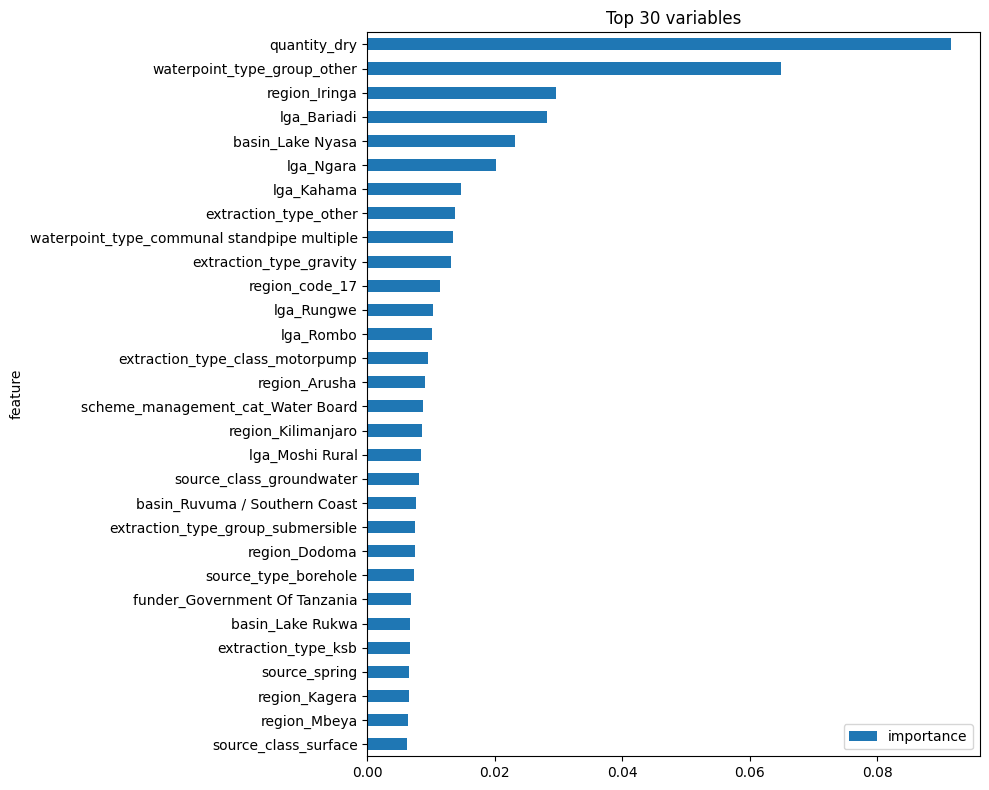

In [76]:
# Extraer pasos del pipeline
preprocesador = pipeline_xgb_rare.named_steps['preprocessor']
modelo = pipeline_xgb_rare.named_steps['classifier']

# Obtener nombres manualmente de columnas transformadas
def obtener_nombres_columnas_transformadas(preprocessor):
    nombres_finales = []

    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if isinstance(transformer, Pipeline):
            ultimo_step = transformer.steps[-1][1]
        else:
            ultimo_step = transformer
        try:
            nombres = ultimo_step.get_feature_names_out(columns)
        except:
            nombres = columns  # fallback si no tiene m√©todo
        nombres_finales.extend(nombres)
    return nombres_finales

columnas_transformadas = obtener_nombres_columnas_transformadas(preprocesador)

# Obtener importancias
importancias = modelo.feature_importances_

# Crear DataFrame con importancias
importancias_df = pd.DataFrame({
    'feature': columnas_transformadas,
    'importance': importancias
}).sort_values(by='importance', ascending=False)

# Visualizar top 30
importancias_df.head(30).plot.barh(x='feature', y='importance', figsize=(10, 8), title="Top 30 variables")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Paso 6: Guardar top 50
top_vars_xgb_rare_001 = importancias_df.head(50)['feature'].tolist()

In [77]:
len(importancias_df)


321

### MODELO XGBOOST CON LAS 100 VARIABLES M√ÅS IMPORTANTES

In [79]:
# Seleccionar top 100 columnas transformadas
top_100_vars = importancias_df.head(100)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top100 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_100_vars]
X_top100 = X_top100.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top100 = XGBClassifier(random_state=42, eval_metric='mlogloss')
modelo_top100.fit(X_top100, y_full)

# Evaluaci√≥n por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    modelo_top100,
    X_top100,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
import numpy as np
print("\n Resultados CV para XGBoost con top 100 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top100,
    nombre_modelo="XGBoost_top100_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_100_vars,
    metrics=metrics,
    params={"rare_threshold": 0.01, "n_top_vars": 100}
)


 Resultados CV para XGBoost con top 100 variables importantes:
 Accuracy medio:     0.7857
 F1 macro medio:     0.6463
 F1 weighted medio:  0.7726


2025/04/30 13:53:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO XGBOOST CON LAS 200 VARIABLES M√ÅS IMPORTANTES

In [80]:
# Seleccionar top 100 columnas transformadas
top_200_vars = importancias_df.head(200)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top200 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_200_vars]
X_top200 = X_top200.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top200 = XGBClassifier(random_state=42, eval_metric='mlogloss')
modelo_top200.fit(X_top200, y_full)

# Evaluaci√≥n por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    modelo_top200,
    X_top200,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
import numpy as np
print("\n Resultados CV para XGBoost con top 200 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top200,
    nombre_modelo="XGBoost_top200_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_200_vars,
    metrics=metrics,
    params={"rare_threshold": 0.01, "n_top_vars": 200}
)


 Resultados CV para XGBoost con top 200 variables importantes:
 Accuracy medio:     0.7984
 F1 macro medio:     0.6669
 F1 weighted medio:  0.7869


2025/04/30 14:00:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO XGBOOST CON LAS 200 VARIABLES M√ÅS IMPORTANTES

In [88]:
# Seleccionar top 100 columnas transformadas
top_225_vars = importancias_df.head(225)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top225 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_225_vars]
X_top225 = X_top225.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top225 = XGBClassifier(random_state=42, eval_metric='mlogloss')
modelo_top225.fit(X_top225, y_full)

# Evaluaci√≥n por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    modelo_top225,
    X_top225,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
import numpy as np
print("\n Resultados CV para XGBoost con top 225 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top225,
    nombre_modelo="XGBoost_top225_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_225_vars,
    metrics=metrics,
    params={"rare_threshold": 0.01, "n_top_vars": 225}
)


 Resultados CV para XGBoost con top 200 variables importantes:
 Accuracy medio:     0.7978
 F1 macro medio:     0.6656
 F1 weighted medio:  0.7862


2025/04/30 14:46:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO XGBOOST CON LAS 150 VARIABLES M√ÅS IMPORTANTES

In [81]:
# Seleccionar top 100 columnas transformadas
top_150_vars = importancias_df.head(150)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top150 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_150_vars]
X_top150 = X_top150.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top150 = XGBClassifier(random_state=42, eval_metric='mlogloss')
modelo_top150.fit(X_top150, y_full)

# Evaluaci√≥n por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    modelo_top150,
    X_top150,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
import numpy as np
print("\n Resultados CV para XGBoost con top 200 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top150,
    nombre_modelo="XGBoost_top150_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_150_vars,
    metrics=metrics,
    params={"rare_threshold": 0.01, "n_top_vars": 150}
)


 Resultados CV para XGBoost con top 200 variables importantes:
 Accuracy medio:     0.7962
 F1 macro medio:     0.6623
 F1 weighted medio:  0.7842


2025/04/30 14:07:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO XGBOOST CON LAS 250 VARIABLES M√ÅS IMPORTANTES

In [82]:
# Seleccionar top 250 columnas transformadas
top_250_vars = importancias_df.head(250)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top250 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_250_vars]
X_top250 = X_top250.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top250 = XGBClassifier(random_state=42, eval_metric='mlogloss')
modelo_top250.fit(X_top250, y_full)

# Evaluaci√≥n por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    modelo_top250,
    X_top250,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
import numpy as np
print("\n Resultados CV para XGBoost con top 250 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top250,
    nombre_modelo="XGBoost_top250_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_250_vars,
    metrics=metrics,
    params={"rare_threshold": 0.01, "n_top_vars": 250}
)



 Resultados CV para XGBoost con top 250 variables importantes:
 Accuracy medio:     0.7966
 F1 macro medio:     0.6640
 F1 weighted medio:  0.7848


2025/04/30 14:10:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Selecci√≥n de variables en Random Forest

In [83]:
# Pipeline con RareLabel (threshold=0.01)
high_card_pipeline_rare_001 = Pipeline(steps=[
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.01)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipelines restantes (iguales para todos)
medium_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
binary_pipeline = Pipeline([
    ('identity', FunctionTransformer(validate=False))
])

# ColumnTransformer con RareLabel (th=0.01)
preprocessor_rare_001 = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline_rare_001, high_card_vars),
    ('medium_card', medium_card_pipeline, medium_card_vars),
    ('low_card', low_card_pipeline, one_hot_vars),
    ('binary', binary_pipeline, binary_vars),
    ('numeric', 'passthrough', num_vars)
])

# Pipeline completo
pipeline_rf_rare_001 = Pipeline([
    ('preprocessor', preprocessor_rare_001),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Evaluaci√≥n con validaci√≥n cruzada
scores_rf_rare_001 = evaluar_modelo_cv_multiclase(
    pipeline_rf_rare_001, X_full, y_full,
    nombre="Random Forest + RareLabel + OneHot (th=0.01)"
)

# Entrenamiento final del modelo
pipeline_rf_rare_001.fit(X_full, y_full)


 Resultados CV para Random Forest + RareLabel + OneHot (th=0.01) (5-fold):
 Accuracy medio:     0.8028
 F1 macro medio:     0.6890
 F1 weighted medio:  0.7979


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('high_card',
                                                  Pipeline(steps=[('rare',
                                                                   RareLabelEncoder(variables=['funder',
                                                                                               'installer',
                                                                                               'ward',
                                                                                               'lga',
                                                                                               'subvillage_cat',
                                                                                               'subvillage_imp'])),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['funder', 'installer',
                                                   'ward', 'lga',
                                                   'subvillage_cat',
                                                   'subvillage_imp']),
                                                 ('mediu...
                                                  Pipeline(steps=[('identity',
                                                                   FunctionTransformer())]),
                                                  ['has_construction_info',
                                                   'zero_amount_tsh',
                                                   'low_amount_tsh',
                                                   'public_meeting_imp',
                                                   'permit_imp']),
                                                 ('numeric', 'passthrough',
                                                  ['amount_tsh_log',
                                                   'gps_height_imp',
                                                   'longitude_imp', 'latitude',
                                                   'age', 'population',
                                                   'year_recorded',
                                                   'month_recorded',
                                                   'recorded_quarter'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Extracci√≥n de variables m√°s importantes para RandomForest y construcci√≥n de modelos.
Exactamente igual que hemos procedido con el modelo de XGBoost, extraeremos las variables m√°s importantes para el modelo RandomForest y construiremos distintos modelos probando diferentes de las mismas para la construcci√≥n del modelo.

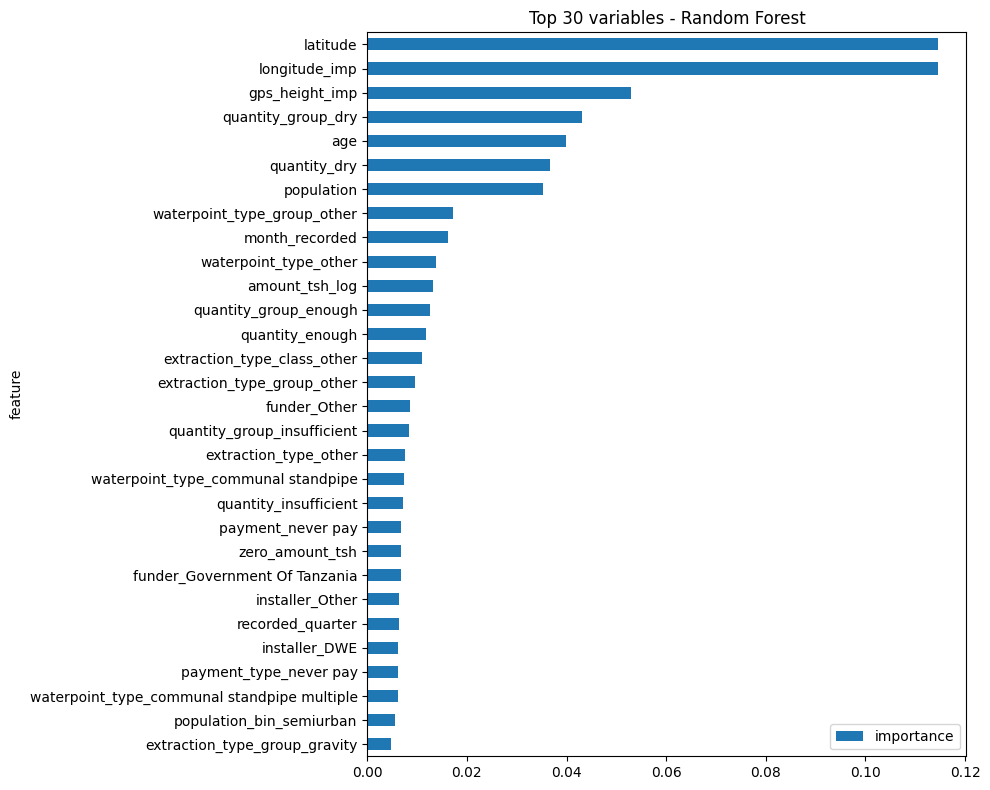

In [85]:
# Extraer pasos del pipeline
preprocesador_rf = pipeline_rf_rare_001.named_steps['preprocessor']
modelo_rf = pipeline_rf_rare_001.named_steps['classifier']

# Obtener nombres manualmente de columnas transformadas
def obtener_nombres_columnas_transformadas(preprocessor):
    nombres_finales = []
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if isinstance(transformer, Pipeline):
            ultimo_step = transformer.steps[-1][1]
        else:
            ultimo_step = transformer
        try:
            nombres = ultimo_step.get_feature_names_out(columns)
        except:
            nombres = columns
        nombres_finales.extend(nombres)
    return nombres_finales

columnas_transformadas_rf = obtener_nombres_columnas_transformadas(preprocesador_rf)

# Obtener importancias
importancias_rf = modelo_rf.feature_importances_

# Crear DataFrame con importancias
importancias_df_rf = pd.DataFrame({
    'feature': columnas_transformadas_rf,
    'importance': importancias_rf
}).sort_values(by='importance', ascending=False)

# Visualizar top 30
importancias_df_rf.head(30).plot.barh(x='feature', y='importance', figsize=(10, 8), title="Top 30 variables - Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Guardar top 50
top_vars_rf_rare_001 = importancias_df_rf.head(50)['feature'].tolist()


### MODELO RANDOM FOREST CON LAS 100 VARIABLES M√ÅS IMPORTANTES

In [86]:
# Seleccionar top 100 columnas transformadas
top_100_vars_rf = importancias_df_rf.head(100)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado_rf = preprocesador_rf.transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top100_rf = pd.DataFrame(X_full_transformado_rf, columns=columnas_transformadas_rf, index=X_full.index)[top_100_vars_rf]
X_top100_rf = X_top100_rf.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top100_rf = RandomForestClassifier(random_state=42)
modelo_top100_rf.fit(X_top100_rf, y_full)

# Evaluaci√≥n por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_rf = cross_validate(
    modelo_top100_rf,
    X_top100_rf,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
print("\n Resultados CV para Random Forest con top 100 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores_rf['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores_rf['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores_rf['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics_rf = {
    "accuracy": np.mean(scores_rf['test_accuracy']),
    "f1_macro": np.mean(scores_rf['test_f1_macro']),
    "f1_weighted": np.mean(scores_rf['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top100_rf,
    nombre_modelo="RandomForest_top100_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_100_vars_rf,
    metrics=metrics_rf,
    params={"rare_threshold": 0.01, "n_top_vars": 100}
)


 Resultados CV para Random Forest con top 100 variables importantes:
 Accuracy medio:     0.8026
 F1 macro medio:     0.6893
 F1 weighted medio:  0.7977


2025/04/30 14:23:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### MODELO RANDOM FOREST CON LAS 200 VARIABLES M√ÅS IMPORTANTES

In [87]:
# Seleccionar top 200 columnas transformadas
top_200_vars_rf = importancias_df_rf.head(200)['feature'].tolist()

# Transformar X_full con el preprocesador ya entrenado
X_full_transformado_rf = preprocesador_rf.transform(X_full)

# Crear DataFrame con las columnas transformadas
X_top200_rf = pd.DataFrame(X_full_transformado_rf, columns=columnas_transformadas_rf, index=X_full.index)[top_200_vars_rf]
X_top200_rf = X_top200_rf.apply(pd.to_numeric, errors='coerce')

# Entrenar modelo con solo esas columnas
modelo_top200_rf = RandomForestClassifier(random_state=42)
modelo_top200_rf.fit(X_top200_rf, y_full)

# Evaluaci√≥n por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_rf = cross_validate(
    modelo_top200_rf,
    X_top200_rf,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

# Mostrar resultados
print("\n Resultados CV para Random Forest con top 200 variables importantes:")
print(f" Accuracy medio:     {np.mean(scores_rf['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores_rf['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores_rf['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics_rf = {
    "accuracy": np.mean(scores_rf['test_accuracy']),
    "f1_macro": np.mean(scores_rf['test_f1_macro']),
    "f1_weighted": np.mean(scores_rf['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=modelo_top200_rf,
    nombre_modelo="RandomForest_top200_importancias",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_200_vars_rf,
    metrics=metrics_rf,
    params={"rare_threshold": 0.01, "n_top_vars": 200}
)



 Resultados CV para Random Forest con top 200 variables importantes:
 Accuracy medio:     0.8040
 F1 macro medio:     0.6899
 F1 weighted medio:  0.7991


2025/04/30 14:29:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Selecci√≥n del mejor modelo para su posterior mejora.
Una vez hemos determinado cual es el mejor modelo y la mejor combinaci√≥n de variables, habiendo resultado el modelo XGBoost con las 200 variables m√°s importantes, seleccionaremos este modelo para intentar realizar mejoras por diferentes t√©cnicas para intentar mejorar sus m√©tricas.

In [ ]:
# Definir los datos
top_200_vars = importancias_df.head(200)['feature'].tolist()
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)
X_top200 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_200_vars]
X_top200 = X_top200.apply(pd.to_numeric, errors='coerce')

# Definir el modelo y los hiperpar√°metros a ajustar
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Configurar la validaci√≥n cruzada y el grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo
grid_search.fit(X_top200, y_full)

# Extraer el mejor modelo y m√©tricas
mejor_modelo = grid_search.best_estimator_
mejores_params = grid_search.best_params_

# Evaluaci√≥n cruzada con el mejor modelo
scores = cross_validate(
    mejor_modelo,
    X_top200,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

print("\n Resultados CV con XGBoost tuneado (top 200 variables):")
print(f" Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f" F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f" F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# 6. Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=mejor_modelo,
    nombre_modelo="XGBoost_top200_tuneado",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_200_vars,
    metrics=metrics,
    params={**mejores_params, "rare_threshold": 0.01, "n_top_vars": 200}
)


##  Evaluaci√≥n del modelo optimizado con XGBoost y selecci√≥n de variables

Tras realizar un proceso de selecci√≥n de caracter√≠sticas basado en la importancia de las variables, se ha construido un modelo **XGBoost** utilizando las **200 variables m√°s relevantes**. Posteriormente, se ha llevado a cabo una optimizaci√≥n fina de hiperpar√°metros mediante validaci√≥n cruzada estratificada, lo que ha permitido mejorar el rendimiento del modelo de forma notable respecto a la versi√≥n base.

###  Configuraci√≥n del modelo final

- **Codificaci√≥n aplicada**: `RareLabelEncoder (threshold=0.01)` + `OneHotEncoder`
- **N√∫mero de variables seleccionadas**: `200` (seg√∫n importancia en el modelo original)
- **Hiperpar√°metros ajustados**:
  - `n_estimators = 200`
  - `max_depth = 8`
  - `learning_rate = 0.2`
  - `colsample_bytree = 0.6`
  - `subsample = 0.8`

###  Resultados (Validaci√≥n cruzada 5-fold)

- **Accuracy**: **0.8109**
- **F1 macro**: 0.6926
- **F1 weighted**: 0.8029

Este modelo se consolida como el **mejor modelo entrenado hasta el momento** y se usar√° como base para futuros intentos de mejora.



### Prueba de mejor modelo con balanceo de clases

In [97]:
y_full.value_counts(normalize=True)

status_group_num
2.0    0.543081
0.0    0.384242
1.0    0.072677
Name: proportion, dtype: float64

In [101]:
# Recalcular pesos por clase (multiclase)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_full)

#  Definir modelo con mejores hiperpar√°metros encontrados
xgb_balanced = XGBClassifier(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
    eval_metric='mlogloss'
)

# Entrenar el modelo usando sample_weight
xgb_balanced.fit(X_top200, y_full, sample_weight=sample_weights)

# Evaluar con CV usando sample_weight tambi√©n
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    xgb_balanced,
    X_top200,
    y_full,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    fit_params={"sample_weight": sample_weights},
    return_train_score=False
)

# Mostrar resultados
print("\nResultados CV con XGBoost balanceado:")
print(f"Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f"F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f"F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=xgb_balanced,
    nombre_modelo="XGBoost_top200_balanceado",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_200_vars,
    metrics=metrics,
    params={
        "rare_threshold": 0.01,
        "n_top_vars": 200,
        "n_estimators": 200,
        "learning_rate": 0.2,
        "max_depth": 8,
        "subsample": 0.8,
        "colsample_bytree": 0.6,
        "sample_weight": "balanced"
    }
)

C:\Users\migue\anaconda3\envs\ML2025\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



Resultados CV con XGBoost balanceado:
Accuracy medio:     0.7681
F1 macro medio:     0.6827
F1 weighted medio:  0.7802


2025/04/30 16:24:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Hemos tenido una p√©rdida en todas las m√©tricas as√≠ que no continuaremos por esta v√≠a y buscaremos otras opciones de mejora.

### Introducci√≥n de variables complejas
Para mejorar la capacidad predictiva del modelo, se han creado nuevas variables derivadas de relaciones l√≥gicas entre columnas existentes. Estas transformaciones permiten capturar informaci√≥n que no est√° expl√≠cita en las variables originales, como la densidad poblacional relativa, la antig√ºedad del pozo o patrones espaciales.

Las variables a√±adidas han sido:

- **`population_per_height`**: ratio entre la poblaci√≥n abastecida y la altitud del pozo, para detectar concentraciones de poblaci√≥n en zonas bajas.
- **`has_installer_info`**: variable binaria que indica si existe informaci√≥n fiable sobre el instalador del pozo.
- **`is_old_construction`**: identifica si el pozo fue construido antes de 1980, como posible se√±al de desgaste.
- **`lat_long_cluster`**: agrupaci√≥n espacial mediante K-Means sobre latitud y longitud, √∫til para detectar regiones homog√©neas.
- **`amount_tsh_per_capita`**: relaci√≥n entre el volumen de agua disponible (`amount_tsh`) y la poblaci√≥n, como proxy de eficiencia o dotaci√≥n.

Estas nuevas caracter√≠sticas enriquecen el dataset con se√±ales potencialmente relevantes para la predicci√≥n del estado operativo de los pozos.


In [108]:
from sklearn.cluster import KMeans
# Crear nuevas variables complejas
X_full['population_per_height'] = X_full['population'] / (X_full['gps_height_imp'] + 1)
X_full['has_installer_info'] = X_full['installer'].apply(lambda x: 0 if pd.isna(x) or str(x).strip().lower() in ['', '0', 'unknown', 'none'] else 1)
X_full['is_old_construction'] = X_full['construction_year'].apply(lambda x: 1 if x != 0 and x < 1980 else 0)
X_full['amount_tsh_per_capita'] = X_full.apply(lambda row: row['amount_tsh'] / row['population'] if row['population'] > 0 else 0, axis=1)
# Crear nuevas variables complejas (a√±adidas a las que ya tienes)
X_full['lat_long_cluster'] = -1
# Usar variables imputadas de coordenadas
coords = X_full[['latitude', 'longitude_imp']].copy()
coords = coords[(coords['latitude'] != 0) & (coords['longitude_imp'] != 0)]
# Aplicar clustering geogr√°fico
kmeans = KMeans(n_clusters=10, random_state=42)
X_full.loc[coords.index, 'lat_long_cluster'] = kmeans.fit_predict(coords)

In [109]:
X_full.columns

Index(['amount_tsh', 'funder', 'installer', 'latitude', 'num_private', 'basin',
       'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'amount_tsh_log',
       'public_meeting_cat', 'permit_cat', 'scheme_management_cat',
       'subvillage_cat', 'public_meeting_imp', 'permit_imp',
       'scheme_management_imp', 'subvillage_imp', 'gps_height_imp',
       'longitude_imp', 'has_construction_info', 'low_amount_tsh',
       'population_bin', 'year_recorded', 'month_recorded', 'recorded_quarter',
       'age', 'zero_amount_tsh', 'population_per_height', 'has_installer_info',
       'is_old_construction', 'amount_tsh_per_capita', 'lat_long_

In [110]:
X_full

amount_tsh           funder     installer   latitude  num_private  \
id                                                                         
69572      6000.0            Roman         Roman  -9.856322            0   
8776          0.0          Grumeti       GRUMETI  -2.147466            0   
34310        25.0     Lottery Club  World vision  -3.821329            0   
67743         0.0           Unicef        UNICEF -11.155298            0   
19728         0.0      Action In A       Artisan  -1.825359            0   
...           ...              ...           ...        ...          ...   
60739        10.0  Germany Republi           CES  -3.253847            0   
27263      4700.0      Cefa-njombe          Cefa  -9.070629            0   
37057         0.0          Unknown       Unknown  -8.750434            0   
31282         0.0            Malec          Musa  -6.378573            0   
26348         0.0       World Bank         World  -6.747464            0   

                         basin       region  region_code  district_code  \
id                                                                        
69572               Lake Nyasa       Iringa           11              5   
8776             Lake Victoria         Mara           20              2   
34310                  Pangani      Manyara           21              4   
67743  Ruvuma / Southern Coast       Mtwara           90             63   
19728            Lake Victoria       Kagera           18              1   
...                        ...          ...          ...            ...   
60739                  Pangani  Kilimanjaro            3              5   
27263                   Rufiji       Iringa           11              4   
37057                   Rufiji        Mbeya           12              7   
31282                   Rufiji       Dodoma            1              4   
26348              Wami / Ruvu     Morogoro            5              2   

                  lga  ... year_recorded  month_recorded  recorded_quarter  \
id                     ...                                                   
69572          Ludewa  ...          2011               3                 1   
8776        Serengeti  ...          2013               3                 1   
34310       Simanjiro  ...          2013               2                 1   
67743        Nanyumbu  ...          2013               1                 1   
19728         Karagwe  ...          2011               7                 3   
...               ...  ...           ...             ...               ...   
60739             Hai  ...          2013               5                 2   
27263          Njombe  ...          2011               5                 2   
37057         Mbarali  ...          2011               4                 2   
31282        Chamwino  ...          2011               3                 1   
26348  Morogoro Rural  ...          2011               3                 1   

        age zero_amount_tsh population_per_height has_installer_info  \
id                                                                     
69572  12.0               0              0.078361                  1   
8776    3.0               1              0.200000                  1   
34310   4.0               0              0.363901                  1   
67743  27.0               1              0.219697                  1   
19728   NaN               1              0.000000                  1   
...     ...             ...                   ...                ...   
60739  14.0               0              0.103220                  1   
27263  15.0               0              0.046167                  1   
37057   NaN               1              0.000000                  0   
31282   NaN               1              0.000000                  1   
26348   9.0               1              0.781250                  1   

      is_old_construction amount_tsh_per_capita lat_long_cluster  
id                     

### Pruebas con las nuevas variables

In [114]:
# Nuevas variables 
num_vars_ext = num_vars + ['population_per_height', 'amount_tsh_per_capita', 'lat_long_cluster']
binary_vars_ext = binary_vars + ['has_installer_info', 'is_old_construction']

# Preprocesamiento
high_card_pipeline = Pipeline([
    ('rare', RareLabelEncoder(variables=high_card_vars, threshold=0.01)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('high_card', high_card_pipeline, high_card_vars),
    ('medium_card', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), medium_card_vars),
    ('low_card', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), one_hot_vars),
    ('binary', FunctionTransformer(validate=False), binary_vars_ext),
    ('numeric', 'passthrough', num_vars_ext)
])

# Pipeline completo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=200,
        learning_rate=0.2,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.6,
        eval_metric='mlogloss',
        random_state=42
    ))
])
pipeline.fit(X_full, y_full)

# Extraer importancias y seleccionar top 200
modelo = pipeline.named_steps['classifier']
preprocesador = pipeline.named_steps['preprocessor']
def obtener_nombres_columnas_(preprocessor):
    nombres_finales = []
    for nombre, transformador, columnas in preprocessor.transformers_:
        if nombre == 'remainder':
            continue
        if isinstance(transformador, Pipeline):
            ultimo = transformador.steps[-1][1]
        else:
            ultimo = transformador
        try:
            nombres = ultimo.get_feature_names_out(columnas)
        except Exception:
            nombres = columnas  # fallback para los que no lo soportan
        nombres_finales.extend(nombres)
    return nombres_finales

col_names = obtener_nombres_columnas_(preprocesador)
importancias = modelo.feature_importances_
importancias_df = pd.DataFrame({'feature': col_names, 'importance': importancias}).sort_values(by='importance', ascending=False)
top_200 = importancias_df.head(200)['feature'].tolist()
X_trans = preprocesador.transform(X_full)
X_top200 = pd.DataFrame(X_trans, columns=col_names, index=X_full.index)[top_200].apply(pd.to_numeric, errors='coerce')

In [115]:
# Validaci√≥n cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    modelo, X_top200, y_full,
    scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro', 'f1_weighted': 'f1_weighted'},
    cv=cv, return_train_score=False
)

# Resultados
print("\nResultados CV con variables complejas (top 200):")
print(f"Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f"F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f"F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}
registrar_resultado_mlflow(
    modelo=modelo,
    nombre_modelo="XGBoost_top200_engineered",
    nombre_codificacion="RareLabel + OneHot (th=0.01) + engineered",
    variables_usadas=top_200,
    metrics=metrics,
    params={
        "rare_threshold": 0.01,
        "n_top_vars": 200,
        "engineered_features": True,
        "n_estimators": 200,
        "max_depth": 8,
        "learning_rate": 0.2,
        "colsample_bytree": 0.6,
        "subsample": 0.8
    }
)


Resultados CV con variables complejas (top 200):
Accuracy medio:     0.7992
F1 macro medio:     0.6760
F1 weighted medio:  0.7902


2025/04/30 17:13:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [116]:
# Definir el conjunto de datos con las 200 nuevas variables ya seleccionadas
X_top200 = X_top200  
y = y_full           

# Definir modelo base
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Definir la malla de hiperpar√°metros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Configurar la validaci√≥n cruzada y GridSearch
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo
grid_search.fit(X_top200, y)

# Evaluaci√≥n del mejor modelo
mejor_modelo = grid_search.best_estimator_
mejores_params = grid_search.best_params_

scores = cross_validate(
    mejor_modelo,
    X_top200,
    y,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_weighted': 'f1_weighted'
    },
    cv=cv,
    return_train_score=False
)

print("\n Resultados CV con nuevas variables y XGBoost tuneado:")
print(f"Accuracy medio:     {np.mean(scores['test_accuracy']):.4f}")
print(f"F1 macro medio:     {np.mean(scores['test_f1_macro']):.4f}")
print(f"F1 weighted medio:  {np.mean(scores['test_f1_weighted']):.4f}")

# 7. Registrar en MLflow
metrics = {
    "accuracy": np.mean(scores['test_accuracy']),
    "f1_macro": np.mean(scores['test_f1_macro']),
    "f1_weighted": np.mean(scores['test_f1_weighted'])
}

registrar_resultado_mlflow(
    modelo=mejor_modelo,
    nombre_modelo="XGBoost_top200_tuneado_nuevas_vars",
    nombre_codificacion="RareLabel + OneHot (th=0.01) + nuevas variables",
    variables_usadas=top_200,
    metrics=metrics,
    params={**mejores_params, "rare_threshold": 0.01, "n_top_vars": 200}
)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

üîé Resultados CV con nuevas variables y XGBoost tuneado:
Accuracy medio:     0.7992
F1 macro medio:     0.6760
F1 weighted medio:  0.7902


2025/04/30 17:58:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Podemos llegar a la conclusi√≥n de que estas nuevas variables no han mejorado en absoluto el modelo porque las m√©tricas han empeorado y en al buscar los mejores hiperpar√°metros las m√©tricas son las mismas. Intentaremos mejorar por otro lado nuestro modelo.

In [117]:
X_top200

quantity_dry  quantity_group_dry  waterpoint_type_other  \
id                                                               
69572           0.0                 0.0                    0.0   
8776            0.0                 0.0                    0.0   
34310           0.0                 0.0                    0.0   
67743           1.0                 1.0                    0.0   
19728           0.0                 0.0                    0.0   
...             ...                 ...                    ...   
60739           0.0                 0.0                    0.0   
27263           0.0                 0.0                    0.0   
37057           0.0                 0.0                    0.0   
31282           0.0                 0.0                    0.0   
26348           0.0                 0.0                    0.0   

       extraction_type_group_other  lga_Bariadi  waterpoint_type_group_other  \
id                                                                             
69572                          0.0          0.0                          0.0   
8776                           0.0          0.0                          0.0   
34310                          0.0          0.0                          0.0   
67743                          0.0          0.0                          0.0   
19728                          0.0          0.0                          0.0   
...                            ...          ...                          ...   
60739                          0.0          0.0                          0.0   
27263                          0.0          0.0                          0.0   
37057                          0.0          0.0                          0.0   
31282                          0.0          0.0                          0.0   
26348                          0.0          0.0                          0.0   

       lga_Rombo  lga_Ngara  region_Iringa  lga_Kigoma Rural  ...  \
id                                                            ...   
69572        0.0        0.0            1.0               0.0  ...   
8776         0.0        0.0            0.0               0.0  ...   
34310        0.0        0.0            0.0               0.0  ...   
67743        0.0        0.0            0.0               0.0  ...   
19728        0.0        0.0            0.0               0.0  ...   
...          ...        ...            ...               ...  ...   
60739        0.0        0.0            0.0               0.0  ...   
27263        0.0        0.0            1.0               0.0  ...   
37057        0.0        0.0            0.0               0.0  ...   
31282        0.0        0.0            0.0               0.0  ...   
26348        0.0        0.0            0.0               0.0  ...   

       district_code_6  quantity_group_enough  payment_pay monthly  \
id                                                                   
69572              0.0                    1.0                  0.0   
8776               0.0                    0.0                  0.0   
34310              0.0                    1.0                  0.0   
67743              0.0                    0.0                  0.0   
19728              0.0                    0.0                  0.0   
...                ...                    ...                  ...   
60739              0.0                    1.0                  0.0   
27263              0.0                    1.0                  0.0   
37057              0.0                    1.0                  1.0   
31282              0.0                    0.0                  0.0   
26348              0.0                    1.0                  0.0   

       basin_Wami / Ruvu  permit_cat_True  region_code_6  lga_Same  \
id                                                                   
69572                0.0              0.0            0.0       0.0   
8776                 0.0              1.0            0.0       0.0   
34310             

## An√°lisis de errores y matriz de confusi√≥n con el mejor modelo hasta el momento

In [118]:
# Definir modelo con los mejores hiperpar√°metros
xgb_final = XGBClassifier(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.6,
    eval_metric='mlogloss',
    random_state=42
)
# Entrenar con las 200 variables m√°s importantes
xgb_final.fit(X_top200, y_full)
# Predicciones y probabilidades
y_pred = xgb_final.predict(X_top200)
y_proba = xgb_final.predict_proba(X_top200)

 Clasificaci√≥n con umbral por defecto:
              precision    recall  f1-score   support

         0.0       0.90      0.79      0.84     22824
         1.0       0.73      0.40      0.52      4317
         2.0       0.82      0.94      0.88     32259

    accuracy                           0.84     59400
   macro avg       0.82      0.71      0.74     59400
weighted avg       0.84      0.84      0.84     59400



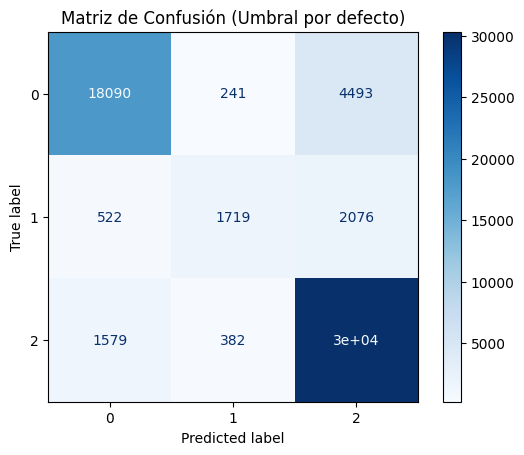

In [122]:
# Matriz de confusi√≥n y reporte con umbral por defecto
print(" Clasificaci√≥n con umbral por defecto:")
print(classification_report(y_full, y_pred))

cm = confusion_matrix(y_full, y_pred)
ConfusionMatrixDisplay(cm, display_labels=xgb_final.classes_).plot(cmap='Blues')
plt.title("Matriz de Confusi√≥n (Umbral por defecto)")
plt.show()

###  An√°lisis de errores con el umbral por defecto

Una vez entrenado el modelo optimizado, se ha evaluado su rendimiento detallado mediante el informe de clasificaci√≥n y la matriz de confusi√≥n. Aunque el modelo alcanza una **accuracy del 84%**, se observa un **claro desequilibrio en el rendimiento entre clases**.

- La clase **1 (functional needs repair)** es la m√°s perjudicada, con un *recall* del **40%** y un *f1-score* de **0.52**, lo que indica que muchos ejemplos de esta clase se est√°n clasificando err√≥neamente como clase 0 o clase 2.
- Por el contrario, la clase **2 (functional)** obtiene el mejor rendimiento con un *recall* del **94%** y un *f1-score* de **0.88**.

Estos resultados muestran que el modelo **tiene un sesgo hacia la clase mayoritaria**, por lo que el siguiente paso ser√° ajustar los umbrales de decisi√≥n personalizados para mejorar la detecci√≥n de la clase minoritaria sin sacrificar el rendimiento general.


In [124]:

# Configuraci√≥n
umbral_clase_1 = 0.2
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# M√©tricas acumuladas
accs = []
f1_macros = []
f1_weighteds = []

for train_idx, val_idx in cv.split(X_top200, y_full):
    X_train, X_val = X_top200.iloc[train_idx], X_top200.iloc[val_idx]
    y_train, y_val = y_full.iloc[train_idx], y_full.iloc[val_idx]

    # Entrenar modelo con mejores hiperpar√°metros
    model = XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.2,
        colsample_bytree=0.6,
        subsample=0.8,
        random_state=42,
        eval_metric='mlogloss'
    )
    model.fit(X_train, y_train)

    # Predicci√≥n de probabilidades y ajuste de umbral clase 1
    y_proba = model.predict_proba(X_val)
    y_pred = []
    for fila in y_proba:
        if fila[1] > umbral_clase_1:
            y_pred.append(1)
        else:
            y_pred.append(np.argmax(fila))

    # Calcular m√©tricas
    accs.append(accuracy_score(y_val, y_pred))
    f1_macros.append(f1_score(y_val, y_pred, average='macro'))
    f1_weighteds.append(f1_score(y_val, y_pred, average='weighted'))

# Promedio de resultados
accuracy = np.mean(accs)
f1_macro = np.mean(f1_macros)
f1_weighted = np.mean(f1_weighteds)

print("\n Resultados CV ajustando umbral clase 1:")
print(f" Accuracy medio:     {accuracy:.4f}")
print(f" F1 macro medio:     {f1_macro:.4f}")
print(f" F1 weighted medio:  {f1_weighted:.4f}")

# Registrar en MLflow
metrics = {
    "accuracy": accuracy,
    "f1_macro": f1_macro,
    "f1_weighted": f1_weighted
}

registrar_resultado_mlflow(
    modelo=model,
    nombre_modelo="XGBoost_top200_umbral_cv",
    nombre_codificacion="RareLabel + OneHot (th=0.01)",
    variables_usadas=top_200,
    metrics=metrics,
    params={
        "rare_threshold": 0.01,
        "n_top_vars": 200,
        "umbral_clase_1": umbral_clase_1,
        "n_estimators": 200,
        "max_depth": 8,
        "learning_rate": 0.2,
        "colsample_bytree": 0.6,
        "subsample": 0.8
    }
)


 Resultados CV ajustando umbral clase 1:
 Accuracy medio:     0.7753
 F1 macro medio:     0.6797
 F1 weighted medio:  0.7802


2025/04/30 18:38:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# GUARDADO DEL MEJOR MODELO PARA PREDICCI√ìN SOBRE EL CONJUNTO DE TEST

In [125]:
resultados_modelos

nombre_modelo  \
0         XGBoost_modelo_base_Rarelabel001   
1         XGBoost_modelo_base_Rarelabel001   
2         XGBoost_modelo_base_Rarelabel005   
3        XGBoost_modelo_base_TargetEncoder   
4    RandomForest_modelo_base_Rarelabel001   
5    RandomForest_modelo_base_Rarelabel005   
6   RandomForest_modelo_base_TargetEncoder   
7              XGBoost_top100_importancias   
8              XGBoost_top200_importancias   
9              XGBoost_top150_importancias   
10             XGBoost_top250_importancias   
11        RandomForest_top100_importancias   
12        RandomForest_top200_importancias   
13             XGBoost_top225_importancias   
14                  XGBoost_top200_tuneado   
15               XGBoost_top200_balanceado   
16               XGBoost_top200_engineered   
17      XGBoost_top200_tuneado_nuevas_vars   
18          XGBoost_top200_umbral_ajustado   
19                XGBoost_top200_umbral_cv   

                                       codificacion  accuracy  f1_macro  \
0                                RareLabel + OneHot  0.798418  0.665391   
1                                RareLabel + OneHot  0.798418  0.665391   
2                                RareLabel + OneHot  0.796818  0.663552   
3                                     TargetEncoder  0.755993  0.636313   
4                                RareLabel + OneHot  0.802778  0.689050   
5                                RareLabel + OneHot  0.802374  0.688529   
6                                     TargetEncoder  0.772542  0.665336   
7                      RareLabel + OneHot (th=0.01)  0.785673  0.646288   
8                      RareLabel + OneHot (th=0.01)  0.798418  0.666879   
9                      RareLabel + OneHot (th=0.01)  0.796229  0.662346   
10                     RareLabel + OneHot (th=0.01)  0.796650  0.664005   
11                     RareLabel + OneHot (th=0.01)  0.802609  0.689329   
12                     RareLabel + OneHot (th=0.01)  0.803973  0.689886   
13                     RareLabel + OneHot (th=0.01)  0.797778  0.665636   
14                     RareLabel + OneHot (th=0.01)  0.810926  0.692567   
15                     RareLabel + OneHot (th=0.01)  0.768148  0.682694   
16        RareLabel + OneHot (th=0.01) + engineered  0.799192  0.676036   
17  RareLabel + OneHot (th=0.01) + nuevas variables  0.799192  0.676036   
18                     RareLabel + OneHot (th=0.01)  0.828367  0.758899   
19                     RareLabel + OneHot (th=0.01)  0.775269  0.679722   

    f1_weighted                                             params  
0      0.786598                           {'rare_threshold': 0.01}  
1      0.786598                           {'rare_threshold': 0.01}  
2      0.785097                           {'rare_threshold': 0.05}  
3      0.748371                              {'encoder': 'target'}  
4      0.797924                           {'rare_threshold': 0.01}  
5      0.797407                           {'rare_threshold': 0.05}  
6      0.768277                                                  -  
7      0.772593        {'rare_threshold': 0.01, 'n_top_vars': 100}  
8      0.786948        {'rare_threshold': 0.01, 'n_top_vars': 200}  
9      0.784198        {'rare_threshold': 0.01, 'n_top_vars': 150}  
10     0.784814        {'rare_threshold': 0.01, 'n_top_vars': 250}  
11     0.797662        {'rare_threshold': 0.01, 'n_top_vars': 100}  
12     0.799056        {'rare_threshold': 0.01, 'n_top_vars': 200}  
13     0.786162        {'rare_threshold': 0.01, 'n_top_vars': 225}  
14     0.802910  {'colsample_bytree': 0.6, 'learning_rate': 0.2...  
15     0.780241  {'rare_threshold': 0.01, 'n_top_vars': 200, 'n...  
16     0.790246  {'rare_threshold': 0.01, 'n_top_vars': 200, 'e...  
17     0.790246  {'colsample_bytree': 0.6, 'learning_rate': 0.2...  
18     0.832525  {'rare_threshold': 0.01, 'n_top_vars': 200, 'u...  
19     0.780203  {'rare_threshold': 0.01, 'n_top_vars': 200, 'u...

### Elecci√≥n final, guardado y predicci√≥n: XGBoost_top200_tuneado que tiene las mejores m√©tricas de todas las pruebas realizadas

In [126]:
# Transformar X_full con preprocesador ya entrenado
X_full_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_full)
X_top200 = pd.DataFrame(X_full_transformado, columns=columnas_transformadas, index=X_full.index)[top_200_vars]
X_top200 = X_top200.apply(pd.to_numeric, errors='coerce')

# Entrenar el mejor modelo
xgb_final = XGBClassifier(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.6,
    eval_metric='mlogloss',
    random_state=42
)
xgb_final.fit(X_top200, y_full)

# Guardar modelo y variables
joblib.dump(xgb_final, "modelo_xgb_final.pkl")
joblib.dump(top_200_vars, "top_200_vars.pkl")
joblib.dump(columnas_transformadas, "columnas_transformadas.pkl")
joblib.dump(pipeline_xgb_rare, "pipeline_xgb_rare.pkl")

['pipeline_xgb_rare.pkl']

In [130]:
# Cargar modelo y objetos necesarios
xgb_final = joblib.load("modelo_xgb_final.pkl")
top_200_vars = joblib.load("top_200_vars.pkl")
columnas_transformadas = joblib.load("columnas_transformadas.pkl")
pipeline_xgb_rare = joblib.load("pipeline_xgb_rare.pkl")

# Cargar test
X_test = pd.read_parquet("X_test_preparado.parquet")

# Transformar y seleccionar variables
X_test_transformado = pipeline_xgb_rare.named_steps['preprocessor'].transform(X_test)
X_test_top200 = pd.DataFrame(X_test_transformado, columns=columnas_transformadas, index=X_test.index)[top_200_vars]
X_test_top200 = X_test_top200.apply(pd.to_numeric, errors='coerce')

# Predecir
y_pred = xgb_final.predict(X_test_top200)

# Mapear predicciones a etiquetas reales
mapeo_etiquetas = {
    0: 'non functional',
    1: 'functional needs repair',
    2: 'functional'
}
y_pred_labels = pd.Series(y_pred).map(mapeo_etiquetas)

# Crear archivo de env√≠o en el formato requerido
df_submission = pd.DataFrame({
    'id': X_test.index,
    'status_group': y_pred_labels
})
df_submission.to_csv("submission.csv", index=False)